In [3]:
%pip install pyarrow==15.0.2

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 32.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: /home/jeintron/dev/blf_m/attractor.3.11.venv/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
trace = pd.read_feather("./data_for_icwsm/icwsmtuned_random_invert_0_umap_clustered_35_trace.feather")
# See here: https://github.com/tensorflow/tensorflow/issues/68335


In [4]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2024-06-28 15:37:56.075473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 15:37:56.185180: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 15:37:56.187335: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-28 15:37:56.351702: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-28 15:37:57.497410: W tensorflow/compiler/tf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
df = trace[["u_id","x","y","dt"]]
grid_size = 50
df['x_grid'] = ((df['x'] - df['x'].min()) / (df['x'].max() - df['x'].min()) * (grid_size - 1)).astype(int)
df['y_grid'] = ((df['y'] - df['y'].min()) / (df['y'].max() - df['y'].min()) * (grid_size - 1)).astype(int)

# Sort by user and datetime to ensure correct transition order
df.sort_values(['u_id', 'dt'], inplace=True)

# Calculate transitions
df['from_x'] = df['x_grid'].shift(1)
df['from_y'] = df['y_grid'].shift(1)
df['to_x'] = df['x_grid']
df['to_y'] = df['y_grid']

# Filter out rows that do not represent a transition (first occurrence for each user)
transitions = df[df['u_id'] == df['u_id'].shift(1)]

# Count transitions
#transitions = df.groupby(['from_x', 'from_y', 'to_x', 'to_y']).size().reset_index(name='count')
transitions

/tmp/ipykernel_101640/3299284823.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_grid'] = ((df['x'] - df['x'].min()) / (df['x'].max() - df['x'].min()) * (grid_size - 1)).astype(int)


,u_id,x,y,dt,x_grid,y_grid,from_x,from_y,to_x,to_y
0,12428,21.852156,-5.451804,2020-10-05 13:11:46+00:00,15,13,16.0,16.0,15,13
50405,12428,22.517124,-4.323751,2020-10-06 01:30:51+00:00,18,18,15.0,13.0,18,18
50406,12428,23.640362,-2.489461,2020-10-06 01:36:42+00:00,23,25,18.0,18.0,23,25
50408,29283,26.746895,-3.141624,2020-08-08 22:40:35+00:00,37,22,21.0,16.0,37,22
50409,29283,27.124683,-2.451145,2020-08-11 01:25:22+00:00,38,25,37.0,22.0,38,25
...,...,...,...,...,...,...,...,...,...,...
166283,1305305314875637761,25.819817,-3.943700,2020-10-01 16:28:29+00:00,32,19,34.0,18.0,32,19
166284,1305305314875637761,25.748693,-3.820274,2020-10-05 22:29:09+00:00,32,20,32.0,19.0,32,20
50402,1305305314875637761,25.460497,-3.798409,2020-10-10 13:07:36+00:00,31,20,32.0,20.0,31,20
50403,1305305314875637761,25.509678,-3.810917,2020-10-16 19:57:30+00:00,31,20,31.0,20.0,31,20


In [4]:
transitions['dx'] = transitions['to_x'] - transitions['from_x']
transitions['dy'] = transitions['to_y'] - transitions['from_y']

/tmp/ipykernel_101640/3824843867.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transitions['dx'] = transitions['to_x'] - transitions['from_x']
/tmp/ipykernel_101640/3824843867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transitions['dy'] = transitions['to_y'] - transitions['from_y']


In [5]:
tx = transitions[['from_x','from_y','dx','dy']]
tx

,from_x,from_y,dx,dy
0,16.0,16.0,-1.0,-3.0
50405,15.0,13.0,3.0,5.0
50406,18.0,18.0,5.0,7.0
50408,21.0,16.0,16.0,6.0
50409,37.0,22.0,1.0,3.0
...,...,...,...,...
166283,34.0,18.0,-2.0,1.0
166284,32.0,19.0,0.0,1.0
50402,32.0,20.0,-1.0,0.0
50403,31.0,20.0,0.0,0.0


In [12]:
import gpflow
import tensorflow as tf
import numpy as np

# Ensure your DataFrame is ready
# For example purposes, let's assume df_replicated is already loaded and prepared

# Prepare the data for GPFlow
X_train = tx[['from_x', 'from_y']].values.astype(np.float64)
y_train_dx = tx['dx'].values.reshape(-1, 1).astype(np.float64)
y_train_dy = tx['dy'].values.reshape(-1, 1).astype(np.float64)


In [ ]:
# Define kernels for each component
kernel_dx = gpflow.kernels.Matern52() + gpflow.kernels.White()
kernel_dy = gpflow.kernels.Matern52() + gpflow.kernels.White()

# Create Gaussian Process models for dx and dy
model_dx = gpflow.models.GPR(data=(X_train, y_train_dx), kernel=kernel_dx, mean_function=None)
model_dy = gpflow.models.GPR(data=(X_train, y_train_dy), kernel=kernel_dy, mean_function=None)

# Configure training to use the GPU, if available
tf.config.set_soft_device_placement(True)

# Optimize the models
optimizer = gpflow.optimizers.Scipy()

def optimize_model(model):
    optimizer.minimize(model.training_loss, variables=model.trainable_variables, options={'maxiter': 100})
    
optimize_model(model_dx)
optimize_model(model_dy)

2024-06-28 15:25:30.148637: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46805 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-06-28 15:25:30.148988: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46862 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:4b:00.0, compute capability: 8.6
2024-06-28 15:25:32.942754: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 187394420000 exceeds 10% of free system memory.


In [9]:
tx['from_x']=tx['from_x'].astype(int)
tx['from_y']=tx['from_y'].astype(int)

/tmp/ipykernel_4499/2318655212.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx['from_x']=tx['from_x'].astype(int)
/tmp/ipykernel_4499/2318655212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx['from_y']=tx['from_y'].astype(int)


In [24]:
import numpy as np

def create_tiles(df, tile_size, overlap=0):
    tiles = []
    step = tile_size - overlap
    for x in range(min(df['from_x']), max(df['from_x']), step):
        for y in range(min(df['from_y']), max(df['from_y']), step):
            # Create a tile
            tile = df[(df['from_x'] >= x) & (df['from_x'] < x + tile_size) &
                      (df['from_y'] >= y) & (df['from_y'] < y + tile_size)]
            if not tile.empty:
                tiles.append(tile)
    return tiles

# Example usage
tile_size = 5  # Define tile size and overlap as needed
tiles = create_tiles(tx, tile_size, overlap=2)




In [25]:
import gpflow 
import pickle
import time
import os

def model_tile(tile):
    print(".", end="")
    X_train = tile[['from_x', 'from_y']].values.astype(np.float64)
    y_train_dx = tile['dx'].values.reshape(-1, 1)  # Reshape to be a 2D array with one column
    y_train_dy = tile['dy'].values.reshape(-1, 1)  # Reshape to be a 2D array with one column
    
    kernel_dx = gpflow.kernels.Matern52() + gpflow.kernels.White()
    kernel_dy = gpflow.kernels.Matern52() + gpflow.kernels.White()

    # Create Gaussian Process models for dx and dy
    model_dx = gpflow.models.GPR(data=(X_train, y_train_dx), kernel=kernel_dx, mean_function=None)
    model_dy = gpflow.models.GPR(data=(X_train, y_train_dy), kernel=kernel_dy, mean_function=None)

    # Configure training to use the GPU, if available
    tf.config.set_soft_device_placement(True)
    
    # Optimize the models
    optimizer = gpflow.optimizers.Scipy()
    
    def optimize_model(model):
        optimizer.minimize(model.training_loss, variables=model.trainable_variables, options={'maxiter': 100})
        
    optimize_model(model_dx)
    optimize_model(model_dy)
    return model_dx, model_dy

# Model each tile



for i,tile in enumerate(tiles):
    filename = f"{i}_cc_map_{tile['from_x'].min()}_{tile['from_y'].min()}.pickle"
    if os.path.isfile(filename):
        print(f"Skipping {filename}")
        continue        
    print(f"Processing {i} of {len(tiles)}, {tile.shape[0]} rows...",end="")
    
    start = time.time()
    model = model_tile(tile)
    elapsed = time.time()-start
    print(f"{elapsed} seconds")
    
    with open(filename,"wb") as f:
        pickle.dump(model,f)


Processing 0 of 210, 3 rows....0.6584310531616211 seconds
Processing 1 of 210, 10 rows....0.5574684143066406 seconds
Processing 2 of 210, 28 rows....0.5606732368469238 seconds
Processing 3 of 210, 1993 rows....7.392904043197632 seconds
Processing 4 of 210, 2370 rows....11.480266809463501 seconds
Processing 5 of 210, 223 rows....0.6272132396697998 seconds
Processing 6 of 210, 1066 rows....2.387709379196167 seconds
Processing 7 of 210, 2106 rows....10.420818090438843 seconds
Processing 8 of 210, 586 rows....1.1601951122283936 seconds
Processing 9 of 210, 4 rows....0.5554261207580566 seconds
Processing 10 of 210, 17 rows....0.5248928070068359 seconds
Processing 11 of 210, 435 rows....0.7002549171447754 seconds
Processing 12 of 210, 808 rows....1.3022668361663818 seconds
Processing 13 of 210, 898 rows....1.7937970161437988 seconds
Processing 14 of 210, 1803 rows....8.958163738250732 seconds
Processing 15 of 210, 697 rows....1.6630876064300537 seconds
Processing 16 of 210, 2642 rows....15.6

## Stitching tiles

In [28]:
import pickle
import numpy as np
import pandas as pd

def load_model(filename):
    with open(filename, "rb") as f:
        model_dx, model_dy = pickle.load(f)
    return model_dx, model_dy

def make_predictions(model_dx, model_dy, points):
    # Ensure points are in float64 format
    points = points.astype(np.float64)

    # Predict dx
    y_pred_dx, y_var_dx = model_dx.predict_f(points)
    # Predict dy
    y_pred_dy, y_var_dy = model_dy.predict_f(points)
    
    return y_pred_dx.numpy(), np.sqrt(y_var_dx.numpy()), y_pred_dy.numpy(), np.sqrt(y_var_dy.numpy())

def process_tile(model_dx, model_dy, tile):
    # Generate grid points for predictions within the tile
    from_x_range = np.unique(tile['from_x'])
    from_y_range = np.unique(tile['from_y'])
    mesh_x, mesh_y = np.meshgrid(from_x_range, from_y_range, indexing='ij')
    points = np.vstack([mesh_x.ravel(), mesh_y.ravel()]).T
    
    # Predict vectors and uncertainties
    dx, dx_std, dy, dy_std = make_predictions(model_dx, model_dy, points)
    
    # Format as DataFrame
    result = pd.DataFrame({
        'from_x': mesh_x.ravel(),
        'from_y': mesh_y.ravel(),
        'dx': dx.ravel(),
        'dy': dy.ravel(),
        'dx_std': dx_std.ravel(),
        'dy_std': dy_std.ravel()
    })
    return result

def stitch_tiles(tiles_info, directory="."):
    # Initialize an empty DataFrame for the full vector field
    full_vector_field = pd.DataFrame()
    
    for i, info in enumerate(tiles_info):
        filename = f"{directory}/{i}_cc_map_{info['min_x']}_{info['min_y']}.pickle"
        if not os.path.isfile(filename):
            continue
        model_dx, model_dy = load_model(filename)
        tile_data = info['data']
        tile_result = process_tile(model_dx, model_dy, tile_data)
        
        # Append results, discarding edges if needed
        # For simplicity, assume no edges are discarded in this example
        full_vector_field = pd.concat([full_vector_field, tile_result], ignore_index=True)
    
    return full_vector_field

In [29]:
tiles_info = [{'min_x': tile['from_x'].min(), 'min_y': tile['from_y'].min(), 'data': tile} for tile in tiles]
full_vector_field = stitch_tiles(tiles_info)

In [32]:
merged_vector_field = full_vector_field.groupby(["from_x","from_y"]).mean().reset_index()
merged_vector_field

,from_x,from_y,dx,dy,dx_std,dy_std
0,0,27,8.555983,-0.069047,8.376857,4.418714
1,0,28,8.994556,-0.747286,8.318484,4.314141
2,0,29,9.421128,-1.503415,8.276324,4.241270
3,0,30,10.081006,-1.850068,8.308972,4.450016
4,0,31,11.174262,-3.318808,8.247184,4.357756
...,...,...,...,...,...,...
1689,49,27,-4.580641,0.396324,6.291614,2.390472
1690,49,28,-5.328690,0.468512,6.091291,2.370344
1691,49,29,-7.964642,-0.027698,6.428789,2.351361
1692,49,30,-9.254824,-0.444892,6.945520,2.394102


In [38]:
%pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 26.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.0/306.0 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 29.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 31.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 3.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: /home/jeintron/dev/blf_m/attractor.3.11.venv/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [43]:
df = merged_vector_field.copy()

In [44]:
df

,from_x,from_y,dx,dy,dx_std,dy_std
0,0,27,8.555983,-0.069047,8.376857,4.418714
1,0,28,8.994556,-0.747286,8.318484,4.314141
2,0,29,9.421128,-1.503415,8.276324,4.241270
3,0,30,10.081006,-1.850068,8.308972,4.450016
4,0,31,11.174262,-3.318808,8.247184,4.357756
...,...,...,...,...,...,...
1689,49,27,-4.580641,0.396324,6.291614,2.390472
1690,49,28,-5.328690,0.468512,6.091291,2.370344
1691,49,29,-7.964642,-0.027698,6.428789,2.351361
1692,49,30,-9.254824,-0.444892,6.945520,2.394102


In [45]:
import numpy as np
import pandas as pd



# Assuming 'df' is your dataframe with columns 'dx', 'dy', 'dx_std', and 'dy_std'
df['angle'] = np.arctan2(df['dy'], df['dx'])  # Compute the angle in radians


# Function to calculate angular standard deviation in degrees
def angular_std_degrees(dx, dy, dx_std, dy_std):
    # Vector magnitude
    r = np.sqrt(dx**2 + dy**2)
    # Propagate error to calculate the standard deviation of the angle
    angle_var = (dx**2 * dy_std**2 + dy**2 * dx_std**2) / r**4
    angle_std_radians = np.sqrt(angle_var)
    # Convert from radians to degrees
    angle_std_degrees = np.degrees(angle_std_radians)
    return angle_std_degrees

# Apply function to calculate angular standard deviation in degrees
df['angle_std_deg'] = df.apply(lambda row: angular_std_degrees(row['dx'], row['dy'], row['dx_std'], row['dy_std']), axis=1)
df


,from_x,from_y,dx,dy,dx_std,dy_std,angle,angle_std_deg
0,0,27,8.555983,-0.069047,8.376857,4.418714,-0.008070,29.591785
1,0,28,8.994556,-0.747286,8.318484,4.314141,-0.082892,27.640900
2,0,29,9.421128,-1.503415,8.276324,4.241270,-0.158245,26.344615
3,0,30,10.081006,-1.850068,8.308972,4.450016,-0.181501,25.864399
4,0,31,11.174262,-3.318808,8.247184,4.357756,-0.288706,23.554406
...,...,...,...,...,...,...,...,...
1689,49,27,-4.580641,0.396324,6.291614,2.390472,3.055286,30.438223
1690,49,28,-5.328690,0.468512,6.091291,2.370344,3.053896,25.928708
1691,49,29,-7.964642,-0.027698,6.428789,2.351361,-3.138115,16.915700
1692,49,30,-9.254824,-0.444892,6.945520,2.394102,-3.093558,14.930608


In [51]:
# correcting this for now...
# Ensuring angles are within 0-360 degrees
df['angle_std_deg'] = df['angle_std_deg'] % 360  # Wrap around if exceeding 360


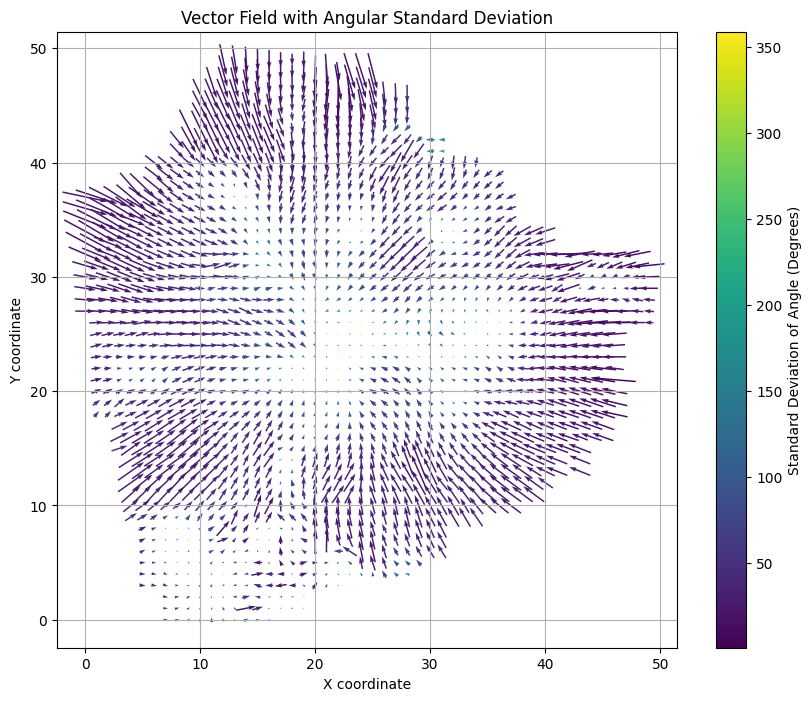

In [53]:

import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
# Use quiver to plot vectors and color by angular standard deviation
Q = ax.quiver(df['from_x'], df['from_y'], df['dx']*.2, df['dy']*.2,
              df['angle_std_deg'], angles='xy', scale_units='xy', scale=1, cmap='viridis', pivot='mid')

# Add a color bar
cbar = fig.colorbar(Q, ax=ax)
cbar.set_label('Standard Deviation of Angle (Degrees)')

ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_title('Vector Field with Angular Standard Deviation')
plt.grid(True)
plt.show()

## Bayesian Update Method

In [7]:
import numpy as np

# def bayesian_update(mu_prior, var_prior, data, epsilon=1e-10):
#     if len(data) == 0:
#         return mu_prior, var_prior
#     mu_sample = np.mean(data)
#     var_sample = np.var(data) if len(data) > 1 else epsilon
#     precision_prior = 1 / var_prior
#     precision_sample = 1 / var_sample
#     combined_precision = precision_prior + len(data) * precision_sample
#     mu_posterior = (precision_prior * mu_prior + len(data) * precision_sample * mu_sample) / combined_precision
#     var_posterior = 1 / combined_precision
#     return mu_posterior, var_posterior

def vector_bayesian_update(mu_prior, var_prior, data, epsilon=1e-10):
    if len(data) == 0:
        return mu_prior, var_prior
    mu_sample = np.mean(data)
    if len(data) > 1:
        var_sample = np.var(data)
    else:
        # Handle single data point variance
        var_sample = (var_prior + epsilon) / 2
    precision_prior = 1 / var_prior
    precision_sample = 1 / var_sample
    n = len(data)
    combined_precision = precision_prior + n * precision_sample
    mu_posterior = (precision_prior * mu_prior + n * precision_sample * mu_sample) / combined_precision
    var_posterior = len(data) / combined_precision
    return mu_posterior, var_posterior


def bayesian_update(mu_prior, var_prior, mean_sample, var_sample, count, epsilon=1e-10):
    if count == 0:
        return mu_prior, var_prior
    if count==1:
        var_sample = (var_prior + epsilon) / 2
    if var_sample==0:
        var_sample = epsilon
    precision_prior = 1 / var_prior
    precision_sample = 1 / var_sample
    combined_precision = precision_prior + count * precision_sample
    mu_posterior = (precision_prior * mu_prior + count * precision_sample * mean_sample) / combined_precision
    var_posterior = count / combined_precision
    return mu_posterior, var_posterior



import numpy as np
import pandas as pd

def prepare_cell_data(df):
    # Group by 'from_x' and 'from_y' and calculate mean and variance
    grouped = df.groupby(['from_x', 'from_y'])
    summary = grouped.agg({
        'dx': ['mean', 'var'],
        'dy': ['mean', 'var','count'],
        
    }).reset_index()
    summary.columns = ['from_x', 'from_y', 'dx_mean', 'dx_var', 'dy_mean', 'dy_var','n']
    # Replace NaN variances (which occur if there's only one sample) with a small positive number
    summary.fillna({'dx_var': 1e-10, 'dy_var': 1e-10}, inplace=True)
    return summary

def process_df(df, mu_prior, var_prior):
    data = prepare_cell_data(df)
    results = []
    for _, row in data.iterrows():
        # Bayesian updates for dx and dy
        mu_dx, var_dx = bayesian_update(mu_prior, var_prior, row['dx_mean'], row['dx_var'], row['n'])
        mu_dy, var_dy = bayesian_update(mu_prior, var_prior, row['dy_mean'], row['dy_var'], row['n'])
        results.append([row['from_x'], row['from_y'], mu_dx, var_dx, mu_dy, var_dy])

    results_df = pd.DataFrame(results, columns=['from_x', 'from_y', 'mu_dx', 'var_dx', 'mu_dy', 'var_dy'])

    # Spatial smoothing would be applied here, using spatial_weighted_average
    return results_df

def spatial_weighted_average(grid, i, j, radius, mu_grid, var_grid):
    weighted_mu, weighted_var, total_weight = 0, 0, 0
    for di in range(-radius, radius + 1):
        for dj in range(-radius, radius + 1):
            ni, nj = i + di, j + dj
            if 0 <= ni < grid.shape[0] and 0 <= nj < grid.shape[1] and (di != 0 or dj != 0):
                weight = 1 / (1 + abs(di) + abs(dj))  # Example weighting scheme
                weighted_mu += weight * mu_grid[ni, nj]
                weighted_var += weight * var_grid[ni, nj]
                total_weight += weight
    if total_weight > 0:
        return weighted_mu / total_weight, weighted_var / total_weight
    return mu_grid[i, j], var_grid[i, j]

def dataframe_to_grid(df):
    # Create mappings from from_x and from_y to indices
    unique_x = np.sort(df['from_x'].unique())
    unique_y = np.sort(df['from_y'].unique())
    x_to_index = {x: idx for idx, x in enumerate(unique_x)}
    y_to_index = {y: idx for idx, y in enumerate(unique_y)}

    # Initialize grids for mu and variance
    mu_dx_grid = np.full((len(unique_x), len(unique_y)), np.nan)
    mu_dy_grid = np.full((len(unique_x), len(unique_y)), np.nan)
    var_dx_grid = np.full((len(unique_x), len(unique_y)), np.nan)
    var_dy_grid = np.full((len(unique_x), len(unique_y)), np.nan)

    # Fill grids with values from DataFrame
    for _, row in df.iterrows():
        i = x_to_index[row['from_x']]
        j = y_to_index[row['from_y']]
        mu_dx_grid[i, j] = row['mu_dx']
        mu_dy_grid[i, j] = row['mu_dy']
        var_dx_grid[i, j] = row['var_dx']
        var_dy_grid[i, j] = row['var_dy']
    return mu_dx_grid, mu_dy_grid, var_dx_grid, var_dy_grid

def grid_to_dataframe(mu_dx_grid, mu_dy_grid, x_grid=None, y_grid = None, var_dx_grid = None, var_dy_grid = None):
    data = []

    
    for i in range(mu_dx_grid.shape[0]):
        for j in range(mu_dx_grid.shape[1]):
            if not np.isnan(mu_dx_grid[i, j]):
                x_coord = i if x_grid is None else x_grid[i,j]
                y_coord = j if y_grid is None else y_grid[i,j]
                row = {
                    'from_x': x_coord,
                    'from_y': y_coord,
                    'mu_dx': mu_dx_grid[i, j],
                    'mu_dy': mu_dy_grid[i, j]}
                if var_dx_grid is not None and var_dy_grid is not None:
                    row['var_dx']=var_dx_grid[i, j]
                    row['var_dy'] = var_dy_grid[i, j]
                data.append(row)

    return pd.DataFrame(data)

def apply_spatial_smoothing(mu_dx_grid, mu_dy_grid, var_dx_grid, var_dy_grid, radius):
    smoothed_mu_dx_grid = np.copy(mu_dx_grid)
    smoothed_mu_dy_grid = np.copy(mu_dy_grid)
    smoothed_var_dx_grid = np.copy(var_dx_grid)
    smoothed_var_dy_grid = np.copy(var_dy_grid)

    for i in range(mu_dx_grid.shape[0]):
        for j in range(mu_dy_grid.shape[1]):
            if not np.isnan(mu_dx_grid[i, j]):
                smoothed_mu_dx_grid[i, j], smoothed_var_dx_grid[i, j] = spatial_weighted_average(
                    mu_dx_grid, i, j, radius, mu_dx_grid, var_dx_grid)
                smoothed_mu_dy_grid[i, j], smoothed_var_dy_grid[i, j] = spatial_weighted_average(
                    mu_dy_grid, i, j, radius, mu_dy_grid, var_dy_grid)

    return smoothed_mu_dx_grid, smoothed_mu_dy_grid, smoothed_var_dx_grid, smoothed_var_dy_grid


# Example usage:
# Assume data_grid is a 2D array where each element is an array of vector measurements for that cell
# length = 4  # Choose a fixed length
# data_grid = np.array([[np.random.randn(length) for _ in range(5)] for _ in range(5)])
# mu_prior, var_prior, radius = 0, 1, 1
# smoothed_mu, smoothed_var = process_grid(data_grid, mu_prior, var_prior, radius)

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_vector_field(df, scale=1):
    
    # Plotting the vector field
    fig, ax = plt.subplots(figsize=(10, 8))
    Q = ax.quiver(
        df['from_x'], df['from_y'], 
        df['mu_dx']*scale, df['mu_dy']*scale,  # Scale the vectors
        angles='xy', scale_units='xy', scale=1,
        pivot='mid'
    )
    
    
    # Set labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Vector Field')
    plt.grid(True)
    plt.show()


def plot_vector_field_with_var(df, scale=1):
    # Calculate the average variance for coloring
    df['avg_var'] = (df['var_dx'] + df['var_dy']) / 2
    
    # Plotting the vector field
    fig, ax = plt.subplots(figsize=(10, 8))
    Q = ax.quiver(
        df['from_x'], df['from_y'], 
        df['mu_dx']*scale, df['mu_dy']*scale,  # Scale the vectors
        df['avg_var'],  # Use average variance for coloring
        angles='xy', scale_units='xy', scale=1,
        cmap='viridis', pivot='mid'
    )
    
    # Adding a color bar to show the variance
    cbar = fig.colorbar(Q, ax=ax)
    cbar.set_label('Average Variance of Vector Components')

    # Set labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Vector Field with Variance Indication')
    plt.grid(True)
    plt.show()

# Example usage of the function
# Assume df is your DataFrame with the necessary columns
# plot_vector_field(df, scale=0.1)  # Adjust scale as needed for your data visualization


In [154]:
sample = [2]

In [161]:
vector_bayesian_update(0,1,sample)

(1.3333333332888888, 0.33333333335555554)

In [164]:
bayesian_update(0,1,np.mean(sample),np.var(sample),1)

(1.3333333332888888, 0.33333333335555554)

In [9]:
smoothed = process_df(tx, 0,1)

In [12]:
smoothed

,from_x,from_y,mu_dx,var_dx,mu_dy,var_dy
0,0.0,30.0,1.333333,0.333333,0.666667,0.333333
1,0.0,31.0,0.307202,5.818701,-0.322581,4.709677
2,0.0,32.0,2.016495,21.378421,-2.677824,14.539749
3,0.0,33.0,8.234147,49.059596,-6.644988,25.200063
4,0.0,34.0,2.136994,16.566388,-3.478031,12.063153
...,...,...,...,...,...,...
1495,48.0,27.0,-1.673367,5.336683,0.421053,3.315789
1496,48.0,28.0,-2.387922,22.588504,1.052749,6.961323
1497,48.0,29.0,-0.338526,6.813621,-0.440840,5.036260
1498,48.0,30.0,-2.000000,0.333333,0.000000,0.333333


In [15]:
averaged

,from_x,from_y,mu_dx,mu_dy,var_dx,var_dy
0,0,31,2.975740,-1.803538,32.613521,15.810554
1,0,32,5.114866,-3.890995,47.907241,21.944397
2,0,33,3.439655,-3.598439,33.570184,17.306620
3,1,31,3.581494,-2.100915,43.431751,17.861581
4,1,32,4.911926,-3.651680,51.620241,24.575512
...,...,...,...,...,...,...
1250,46,28,-1.718207,-0.033212,29.359846,9.847033
1251,46,29,-1.985037,-0.317567,39.479988,8.219885
1252,46,30,-1.599577,-1.019076,34.205499,8.700925
1253,47,28,-1.625052,0.141951,21.164641,7.489894


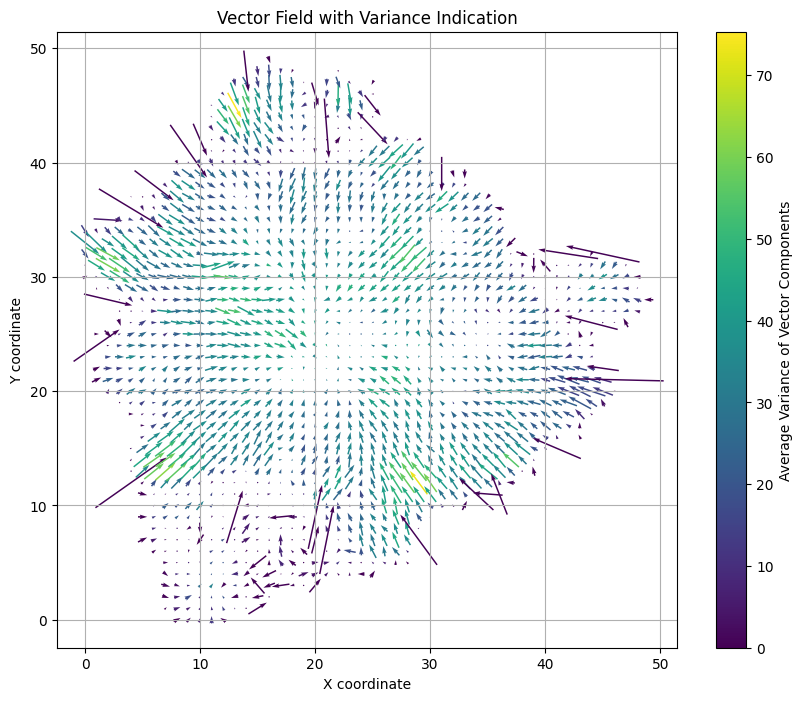

In [191]:
plot_vector_field(smoothed,.3)

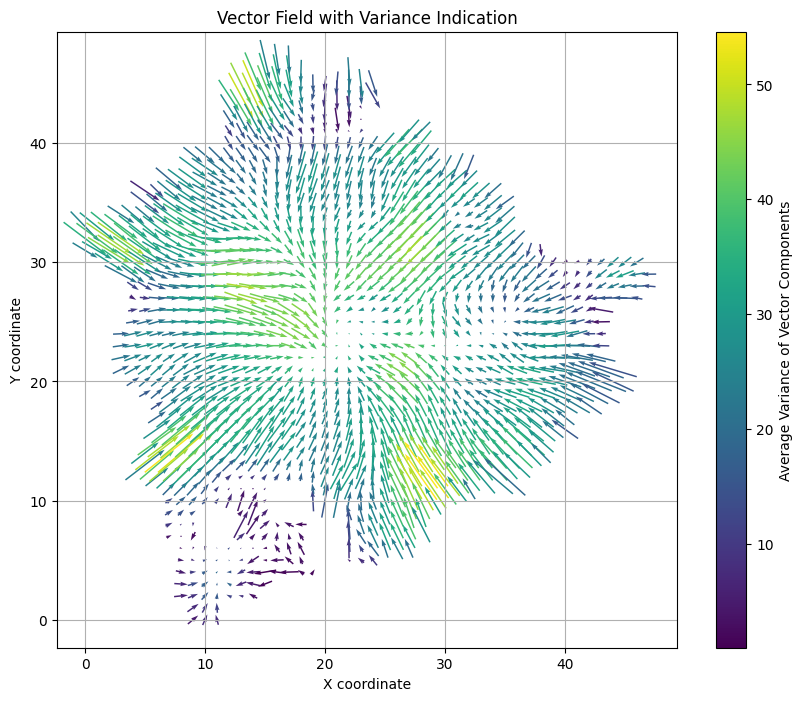

In [17]:
plot_vector_field_with_var(averaged,.7)

## Attractor identification

Convert to vector field arrays

In [209]:
df = averaged.copy()

x_coords = np.sort(df['from_x'].unique())
y_coords = np.sort(df['from_y'].unique())

# Step 2: Create meshgrid
X, Y = np.meshgrid(x_coords, y_coords)

# Step 3: Create U and V arrays
U = np.zeros_like(X,dtype=float)
V = np.zeros_like(Y)

# Step 4: Fill U and V arrays
for index, row in df.iterrows():
    i = np.where(x_coords == row['from_x'])[0][0]
    j = np.where(y_coords == row['from_y'])[0][0]
    U[j, i] = row['mu_dx']
    V[j, i] = row['mu_dy']

# Now X, Y, U, V are ready to use with the vector field analysis code

# Optional: Create array for variance (could be useful for visualization or analysis)
Var = np.zeros_like(X, dtype=[('dx', float), ('dy', float)])
for index, row in df.iterrows():
    i = np.where(x_coords == row['from_x'])[0][0]
    j = np.where(y_coords == row['from_y'])[0][0]
    Var['dx'][j, i] = row['var_dx']
    Var['dy'][j, i] = row['var_dy']

In [318]:
import numpy as np
import pandas as pd
from scipy.interpolate import NearestNDInterpolator
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree
import multiprocessing as mp

class VectorFieldSimulator:
    def __init__(self, df):
        self.df = df
        self._prepare_data()

    def _prepare_data(self):
        # Extract unique x and y coordinates
        self.x_coords = np.sort(self.df['from_x'].unique()).astype(float)
        self.y_coords = np.sort(self.df['from_y'].unique()).astype(float)

        # Create meshgrid
        self.X, self.Y = np.meshgrid(self.x_coords, self.y_coords)

        # Initialize U, V, and Var arrays with NaN
        self.U = np.full_like(self.X, np.nan, dtype=float)
        self.V = np.full_like(self.Y, np.nan, dtype=float)
        self.Var = np.full_like(self.X, np.nan, dtype=[('dx', float), ('dy', float)])

        # Fill U, V, and Var arrays
        for _, row in self.df.iterrows():
            i = np.where(self.x_coords == row['from_x'])[0][0]
            j = np.where(self.y_coords == row['from_y'])[0][0]
            self.U[j, i] = row['mu_dx']
            self.V[j, i] = row['mu_dy']
            self.Var['dx'][j, i] = row['var_dx']
            self.Var['dy'][j, i] = row['var_dy']

        # Create valid data mask
        self.valid_mask = ~np.isnan(self.U) & ~np.isnan(self.V)

        # Set limits
        self.x_min, self.x_max = self.X.min(), self.X.max()
        self.y_min, self.y_max = self.Y.min(), self.Y.max()

        # Create interpolators
        valid_points = np.column_stack((self.X[self.valid_mask], self.Y[self.valid_mask]))
        self.u_interp = NearestNDInterpolator(valid_points, self.U[self.valid_mask])
        self.v_interp = NearestNDInterpolator(valid_points, self.V[self.valid_mask])
        self.var_dx_interp = NearestNDInterpolator(valid_points, self.Var['dx'][self.valid_mask])
        self.var_dy_interp = NearestNDInterpolator(valid_points, self.Var['dy'][self.valid_mask])

    def vector_field_with_variance(self, y):
        """Interpolate the vector field at position y, incorporating variance."""
        x, y = y
        if not (self.x_min <= x <= self.x_max and self.y_min <= y <= self.y_max):
            return np.array([0, 0])  # Return zero vector if outside bounds
        u = self.u_interp([x, y])[0]
        v = self.v_interp([x, y])[0]
        var_dx = self.var_dx_interp([x, y])[0]
        var_dy = self.var_dy_interp([x, y])[0]
        u += np.random.normal(0, np.sqrt(max(var_dx, 0)))
        v += np.random.normal(0, np.sqrt(max(var_dy, 0)))
        return np.array([u, v])

    def simple_integration(self, start, steps=100, dt=0.1):
        """Simple Euler integration method."""
        point = np.array(start)
        trajectory = [point]
        for _ in range(steps):
            delta = self.vector_field_with_variance(point)
            if np.all(delta == 0):  # Stop if we've gone out of bounds
                break
            point += delta * dt
            trajectory.append(point)
        return np.array(trajectory)

    def run_trajectory(self, start_point):
        """Run a single trajectory from a given starting point."""
        trajectory = self.simple_integration(start_point)
        return trajectory[-1], trajectory

    def simulate_trajectories(self, samples_per_cell=5):
        """Find attractors in the vector field, incorporating variance."""
        valid_points = np.column_stack((self.X[self.valid_mask], self.Y[self.valid_mask]))
        num_valid_cells = np.sum(self.valid_mask)
        total_samples = num_valid_cells * samples_per_cell

        start_points = np.repeat(valid_points, samples_per_cell, axis=0)
        start_points += np.random.normal(0, 0.1, size=start_points.shape)  # Add small jitter

        with mp.Pool() as pool:
            results = pool.map(self.run_trajectory, start_points)

        end_points, trajectories = zip(*results)
        end_points = np.array(end_points)
        
        # Filter out end points that are outside the valid data range
        valid_end_points = end_points[
            (end_points[:, 0] >= self.x_min) & (end_points[:, 0] <= self.x_max) &
            (end_points[:, 1] >= self.y_min) & (end_points[:, 1] <= self.y_max)
        ]

        self.trajectories = trajectories
        self.start_points = start_points

        return valid_end_points

    def cluster_end_points(self, valid_end_points, eps=0.5, min_samples=5):
        # Use DBSCAN to cluster end points (potential attractors)
        clustering = DBSCAN(eps=0.5, min_samples=5).fit(valid_end_points)
        
        attractors = []
        for label in set(clustering.labels_):
            if label != -1:  # -1 is noise in DBSCAN
                cluster_points = valid_end_points[clustering.labels_ == label]
                attractors.append(cluster_points.mean(axis=0))
        
 
        return np.array(attractors)

    def assign_to_basins(self, attractors):
        """Assign each valid point in the vector field to a basin of attraction."""
        tree = cKDTree(attractors)
        
        end_points = np.array([traj[-1] for traj in self.trajectories])
        valid_end_points = (
            (end_points[:, 0] >= self.x_min) & (end_points[:, 0] <= self.x_max) &
            (end_points[:, 1] >= self.y_min) & (end_points[:, 1] <= self.y_max)
        )
        
        _, nearest_attractors = tree.query(end_points[valid_end_points])
        
        basins = np.full(self.X.shape, -1)  # -1 represents no basin assignment
        
        for start, basin in zip(self.start_points[valid_end_points], nearest_attractors):
            i = np.clip(np.argmin(np.abs(self.Y[:, 0] - start[1])), 0, self.X.shape[0] - 1)
            j = np.clip(np.argmin(np.abs(self.X[0, :] - start[0])), 0, self.X.shape[1] - 1)
            basins[i, j] = basin
        
        return basins

# Usage
# simulator = VectorFieldSimulator(df)
# attractors = simulator.find_attractors(samples_per_cell=5)
# basins = simulator.assign_to_basins(attractors)

In [316]:
import numpy as np
import matplotlib.pyplot as plt

def plot_vector_field_with_basins(simulator, basins, attractors):
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create a masked array for the basins
    masked_basins = np.ma.masked_where(basins == -1, basins)
    
    # Plot basins heatmap
    im = ax.imshow(masked_basins, extent=[simulator.x_min, simulator.x_max, simulator.y_min, simulator.y_max],
                   origin='lower', aspect='auto', cmap='viridis', alpha=0.7)
    
    # Create a quiver plot of the vector field (only for valid cells)
    mask = simulator.valid_mask
    X_valid = simulator.X[mask]
    Y_valid = simulator.Y[mask]
    U_valid = simulator.U[mask]
    V_valid = simulator.V[mask]
    
    # Normalize the vectors for better visualization
    magnitude = np.sqrt(U_valid**2 + V_valid**2)
    U_normalized = U_valid / magnitude
    V_normalized = V_valid / magnitude
    
    quiver = ax.quiver(X_valid, Y_valid, U_normalized, V_normalized, 
                       color='white', scale=30, width=0.002, alpha=0.7)
    
    # Plot attractors
    ax.scatter(attractors[:, 0], attractors[:, 1], c='red', s=100, label='Attractors', zorder=5)
    
    # Colorbar and labels
    cbar = plt.colorbar(im)
    cbar.set_label('Basin of Attraction')
    
    ax.set_title('Vector Field with Basins of Attraction')
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.legend()
    
    plt.tight_layout()
    plt.show()



In [322]:
simulator = VectorFieldSimulator(averaged)
end_points = simulator.simulate_trajectories(samples_per_cell=20)

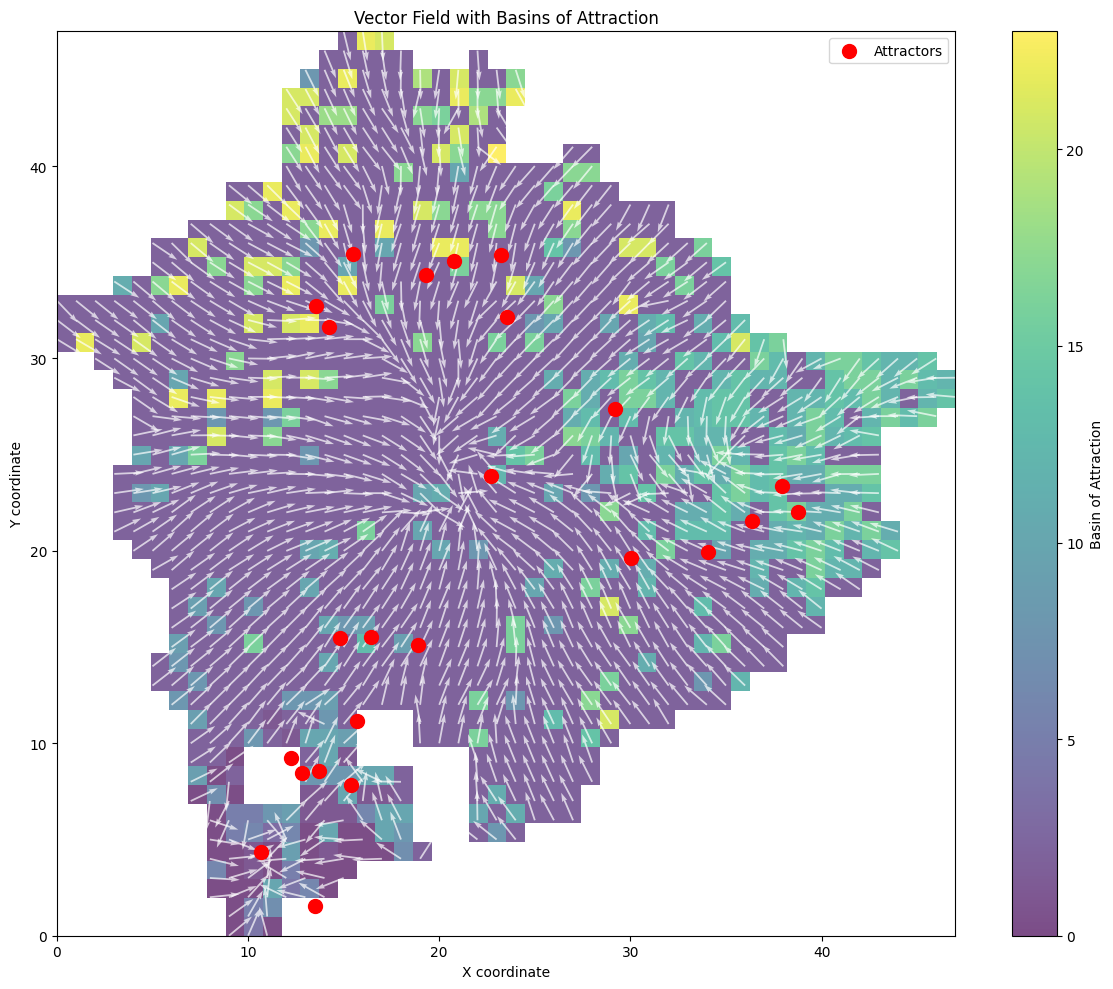

In [327]:
attractors = simulator.cluster_end_points(end_points,eps=3,min_samples=10)
basins = simulator.assign_to_basins(attractors)
plot_vector_field_with_basins(simulator,basins,attractors)

# Take 2

This is not great.  Let's try without variance first.

In [48]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import multiprocessing as mp
from scipy.ndimage import generic_filter
from sklearn.cluster import DBSCAN

class DiscreteVectorFieldAnalyzer:
    def __init__(self, df, interpolation_factor=1):
        self.df = df
        self.interpolation_factor = interpolation_factor
        self._prepare_data()

    def _prepare_data(self):
        # Extract original data
        x = self.df['from_x'].values
        y = self.df['from_y'].values
        u = self.df['mu_dx'].values
        v = self.df['mu_dy'].values
        
        # Create fine grid
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        self.x_fine = np.linspace(x_min, x_max, int((x_max - x_min) * self.interpolation_factor))
        self.y_fine = np.linspace(y_min, y_max, int((y_max - y_min) * self.interpolation_factor))
        self.X_fine, self.Y_fine = np.meshgrid(self.x_fine, self.y_fine)
        
        # Prepare points for interpolation
        points = np.column_stack((x, y))
        
        # Create Delaunay triangulation for the original points
        tri = Delaunay(points)
        
        # Interpolate U and V using LinearNDInterpolator
        self.U_interp = LinearNDInterpolator(points, u, fill_value=np.nan)
        self.V_interp = LinearNDInterpolator(points, v, fill_value=np.nan)
        
        # Apply interpolation
        self.U_fine = self.U_interp(self.X_fine, self.Y_fine)
        self.V_fine = self.V_interp(self.X_fine, self.Y_fine)
        
        # Create mask for valid data points
        # fine_points = np.column_stack((self.X_fine.ravel(), self.Y_fine.ravel()))
        # self.valid_mask = tri.find_simplex(fine_points) >= 0
        # self.valid_mask = self.valid_mask.reshape(self.X_fine.shape)

        # Create a more restrictive mask for valid data points
        fine_points = np.column_stack((self.X_fine.ravel(), self.Y_fine.ravel()))
        in_simplex = tri.find_simplex(fine_points) >= 0
        has_valid_values = ~np.isnan(self.U_fine.ravel()) & ~np.isnan(self.V_fine.ravel())
        self.valid_mask = (in_simplex & has_valid_values).reshape(self.X_fine.shape)
        
        # Apply mask to U_fine and V_fine
        self.U_fine[~self.valid_mask] = np.nan
        self.V_fine[~self.valid_mask] = np.nan
        
        self.grid_shape = self.X_fine.shape



    # def generate_trajectory(self, start_index, max_steps=1000, step_size=0.1):
    #     trajectory = [start_index]
    #     current_point = np.array([self.X_fine[start_index[0], start_index[1]], 
    #                               self.Y_fine[start_index[0], start_index[1]]])
        
    #     for _ in range(max_steps):
    #         i, j = self.discretize_point(current_point)
    #         if not self.valid_mask[i, j]:
    #             break  # Stop if we've left the valid region
            
    #         delta = self.vector_field(i, j)
    #         if np.all(np.abs(delta) < 1e-6):
    #             break  # Stopping point detected
            
    #         next_point = current_point + delta * step_size
    #         next_i, next_j = self.discretize_point(next_point)
            
    #         if not self.valid_mask[next_i, next_j]:
    #             break  # Stop if the next point would be outside the valid region
            
    #         trajectory.append((next_i, next_j))
    #         current_point = next_point
        
    #     return trajectory
    def generate_trajectory(self, start_index, max_steps=1000, step_size=0.1):
        trajectory = [start_index]
        current_point = np.array([self.X_fine[start_index[0], start_index[1]], 
                                  self.Y_fine[start_index[0], start_index[1]]])
        visited = set([start_index])
        
        for _ in range(max_steps):
            i, j = self.discretize_point(current_point)
            if not self.valid_mask[i, j]:
                print("We are out of bounds")
                
            delta = self.vector_field(i, j)
            
            if np.all(np.abs(delta) < 1e-6):
                break  # Stopping point detected
            
            # Euler integration step
            next_point = current_point + delta * step_size
            
            # Discretize the new point to get the next grid index
            next_index = self.discretize_point(next_point)
            
            if not (0 <= next_index[0] < self.grid_shape[0] and 0 <= next_index[1] < self.grid_shape[1]):
                break  # Out of bounds

            if not self.valid_mask[next_index[0], next_index[1]]:
                break 
            
            if next_index in visited:
                break  # Cycle detected
            
            visited.add(next_index)
            trajectory.append(next_index)
            current_point = next_point
        
        return trajectory


    def process_point(self, args):
        index, step_size = args
        trajectory = self.generate_trajectory(index, step_size=step_size)
        return trajectory[-1]

    def analyze_vector_field(self, step_size=0.1):
        valid_indices = list(zip(*np.where(self.valid_mask)))
        
        # Create a list of tuples containing both the index and step_size
        args = [(index, step_size) for index in valid_indices]
        
        with mp.Pool() as pool:
            end_indices = pool.map(self.process_point, args)
        
        return end_indices


    def discretize_point(self, point):
        """Convert a continuous point to the nearest grid index."""
        j = np.clip(np.searchsorted(self.x_fine, point[0]), 0, self.grid_shape[1] - 1)
        i = np.clip(np.searchsorted(self.y_fine, point[1]), 0, self.grid_shape[0] - 1)
        return (int(i), int(j))
        
    # def discretize_point(self, point):
    #     i = np.clip(np.searchsorted(self.y_fine, point[1]) - 1, 0, self.grid_shape[0] - 1)
    #     j = np.clip(np.searchsorted(self.x_fine, point[0]) - 1, 0, self.grid_shape[1] - 1)
        
    #     # Ensure the point is within the valid mask
    #     if not self.valid_mask[i, j]:
    #         # Find the nearest valid point
    #         valid_indices = np.argwhere(self.valid_mask)
    #         distances = np.sum((valid_indices - np.array([i, j]))**2, axis=1)
    #         nearest_valid = valid_indices[np.argmin(distances)]
    #         return tuple(nearest_valid)
        
    #     return (i, j)


    def vector_field(self, i, j):
        """Return the vector field at the given grid indices."""
        return np.array([self.U_fine[i, j], self.V_fine[i, j]])

 
    def find_attractors_and_basins(self, end_indices, threshold=0.1, samples=5):
        valid_indices = list(zip(*np.where(self.valid_mask)))
        # Convert indices to coordinates for clustering
        end_points = np.array([(self.X_fine[i, j], self.Y_fine[i, j]) for i, j in end_indices])
        
        clustering = DBSCAN(eps=threshold, min_samples=samples).fit(end_points)
        
        unique_labels = np.unique(clustering.labels_)
        print(unique_labels)
        attractors = []
        for label in unique_labels:
            if label != -1:  # -1 is noise in DBSCAN
                cluster_points = end_points[clustering.labels_ == label]
                attractors.append(np.mean(cluster_points, axis=0))
        
        attractors = np.array(attractors)
        
        # Assign basins
        basins = np.full(self.grid_shape, -1, dtype=int)
        for (i, j), label in zip(valid_indices, clustering.labels_):
            basins[i, j] = label

       
        
        return attractors, basins

    

    def majority_filter(basins, size=3):
        def most_common(arr):
            if np.all(arr == -1):
                return -1
            values, counts = np.unique(arr[arr != -1], return_counts=True)
            return values[np.argmax(counts)]
        
        smoothed = generic_filter(basins, most_common, size=size, mode='constant', cval=-1)
        return smoothed

    def plot_results(self, attractors, basins):
        plt.figure(figsize=(12, 10))
        masked_basins = np.ma.masked_where(~self.valid_mask, basins)
        plt.imshow(masked_basins, extent=[self.x_fine.min(), self.x_fine.max(), 
                                          self.y_fine.min(), self.y_fine.max()],
                   origin='lower', alpha=0.6, cmap='viridis')
        plt.streamplot(self.X_fine, self.Y_fine, self.U_fine, self.V_fine, 
                       density=3, color='gray', arrowsize=0.5)
        plt.scatter(attractors[:, 0], attractors[:, 1], c='red', s=100, label='Attractors')
        plt.colorbar(label='Basin of Attraction')
        plt.title('Vector Field with Basins of Attraction')
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
        plt.legend()
        plt.show()

# Usage
# analyzer = DiscreteVectorFieldAnalyzer(averaged, interpolation_factor=1)
# end_points, valid_points = analyzer.analyze_vector_field()
# attractors, basins = analyzer.find_attractors_and_basins(end_points, valid_points)
# analyzer.plot_results(attractors, basins)

# Usage


In [49]:
analyzer = DiscreteVectorFieldAnalyzer(averaged, interpolation_factor=4)
end_points = analyzer.analyze_vector_field(step_size=.7)

In [50]:

attractors, basins = analyzer.find_attractors_and_basins(end_points,threshold=1,samples=2)



[0 1 2 3 4]


In [52]:
basins

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

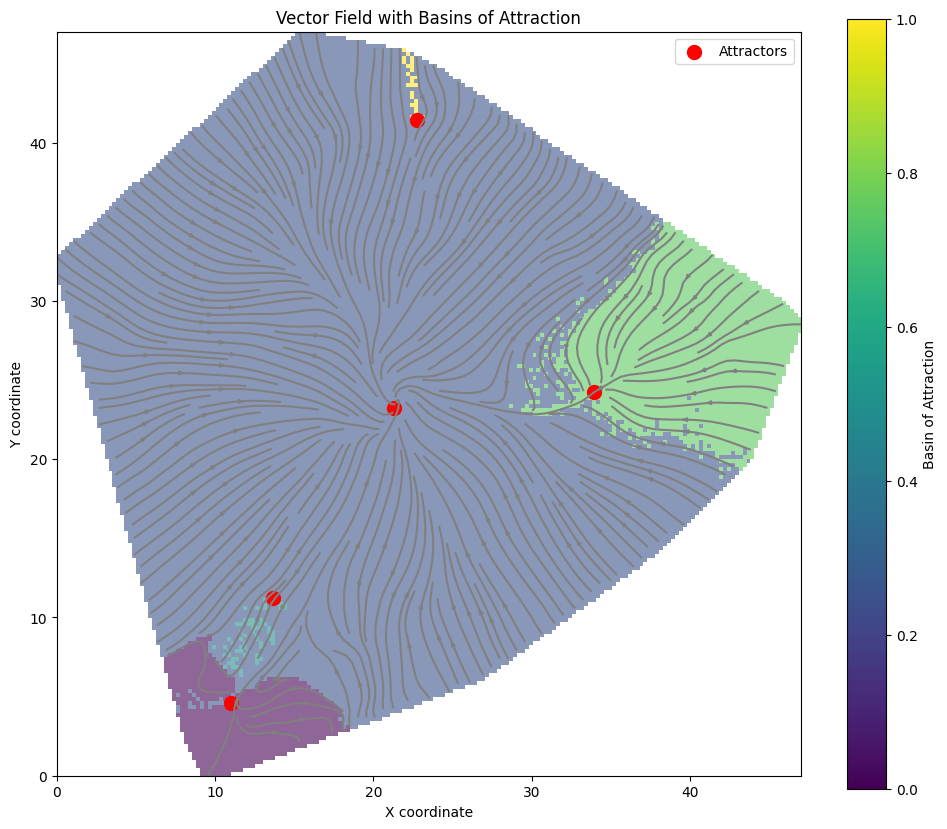

In [22]:
analyzer.plot_results(attractors,basins)

In [159]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

class BasinSmoother:
    def __init__(self, basins, attractors):
        self.basins = basins
        self.attractors = np.array(attractors)
        self.num_attractors = len(attractors)
        self.shape = basins.shape

    def create_basin_mask(self, attractor_index):
        return (self.basins == attractor_index).astype(np.uint8)

    def smooth_basin(self, mask, smoothing_factor=2):
        # Ensure odd-sized kernel by adding 1 if smoothing_factor is even
        kernel_size = smoothing_factor + 1 if smoothing_factor % 2 == 0 else smoothing_factor
        kernel = np.ones((kernel_size, kernel_size), np.uint8)

        # Apply morphological closing to fill small holes and smooth edges
        closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        
        # Apply morphological opening to remove small noise
        #opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
        
        # Find contours of the opened mask
        contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return mask
        
        # Simplify the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        epsilon = 0.002 * cv2.arcLength(largest_contour, True)
        approx = cv2.approxPolyDP(largest_contour, epsilon, True)
        
        # Create a new mask from the simplified contour
        smooth_mask = np.zeros_like(mask)
        cv2.drawContours(smooth_mask, [approx], 0, 1, -1)
        
        # Ensure all original points are included (prevents orphaned points)
        smooth_mask = np.logical_or(smooth_mask, mask).astype(np.uint8)
        
        return smooth_mask

    def process_basins(self, smooth=True, smoothing_factor=2):
        # Calculate basin sizes and strengths
        basin_sizes = np.array([np.sum(self.basins == i) for i in range(self.num_attractors)])
        strengths = 1 / basin_sizes
        strengths = strengths / np.max(strengths)  # Normalize

        # Sort attractors by increasing strength (decreasing basin size)
        sorted_indices = np.argsort(strengths)

        processed_basins = np.full(self.shape, -1, dtype=int)

        for i in sorted_indices:
            mask = self.create_basin_mask(i)
            
            if smooth:
                smooth_mask = self.smooth_basin(mask, smoothing_factor)
            else:
                smooth_mask = mask

            # Update the processed basins
            processed_basins[smooth_mask == 1] = i

        return processed_basins

    def visualize_processed_basins(self, processed_basins, smooth=True):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        
        # Plot original basins
        ax1.imshow(self.basins, cmap='viridis', interpolation='nearest', origin='lower')
        ax1.scatter(self.attractors[:, 0], self.attractors[:, 1], color='red', s=50)
        ax1.set_title("Original Basins")
        
        # Plot processed basins
        ax2.imshow(processed_basins, cmap='viridis', interpolation='nearest', origin='lower')
        ax2.scatter(self.attractors[:, 0], self.attractors[:, 1], color='red', s=50)
        title = "Smoothed Basins" if smooth else "Original Basins with Resolved Overlaps"
        ax2.set_title(title)
        
        plt.show()

In [53]:
np.unique(basins)

array([-1,  0,  1,  2,  3,  4])

In [54]:
attractors

array([[11.01364579,  4.60612753],
       [21.29450048, 23.21627638],
       [13.62964095, 11.23116883],
       [33.91981333, 24.25518417],
       [22.71906035, 41.44365928]])

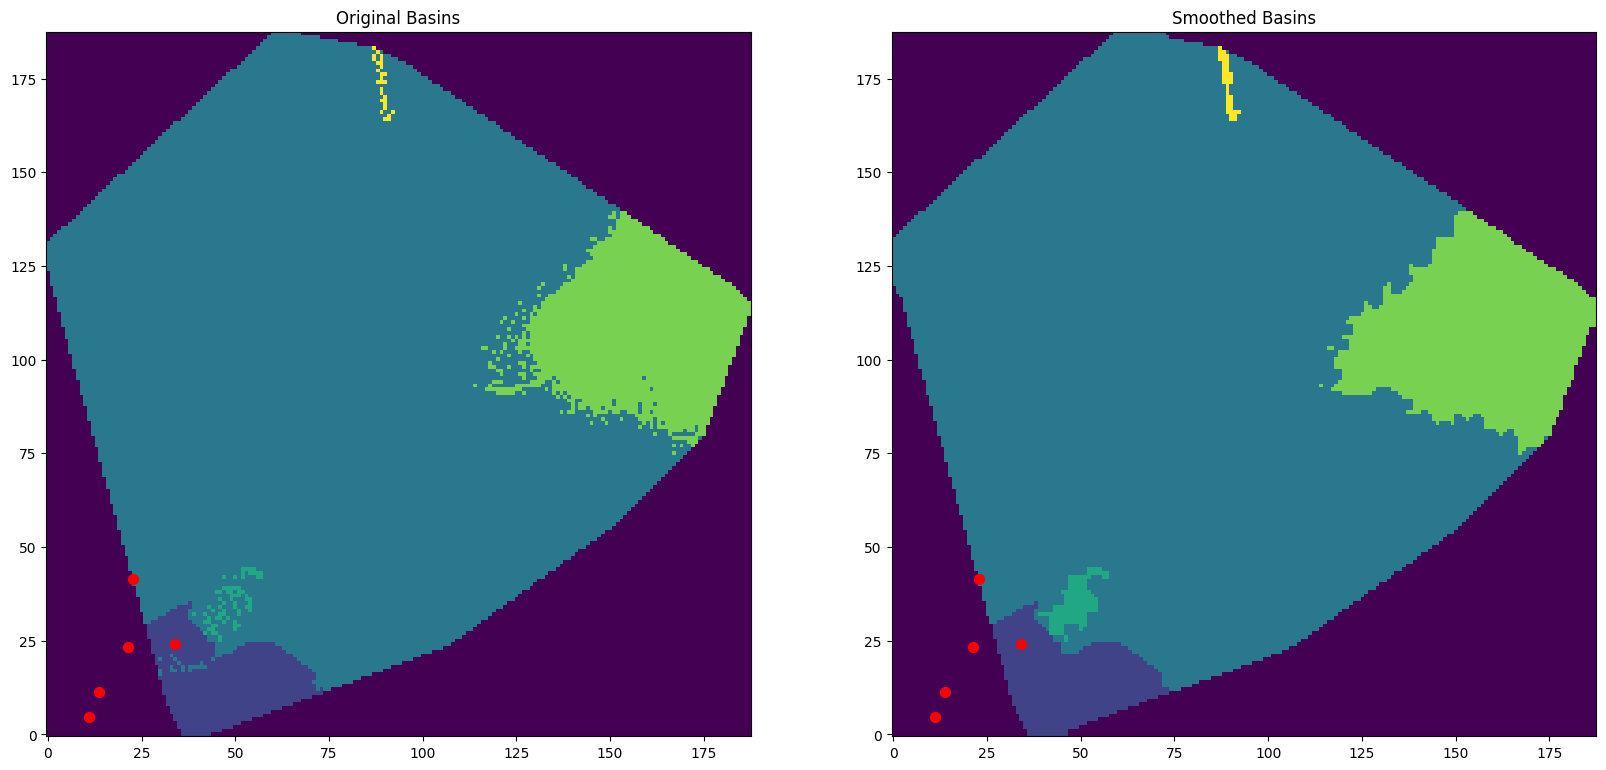

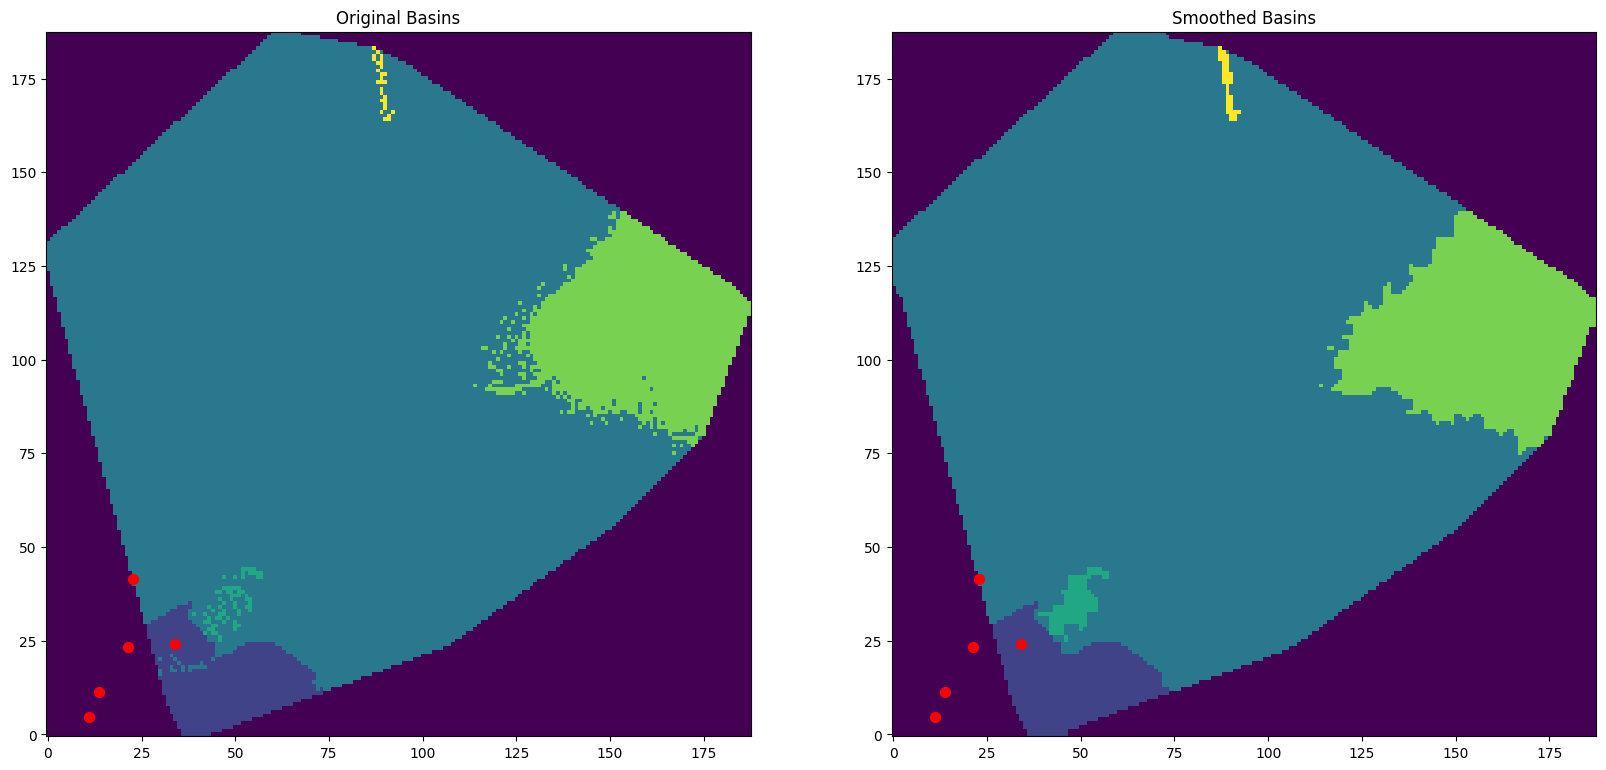

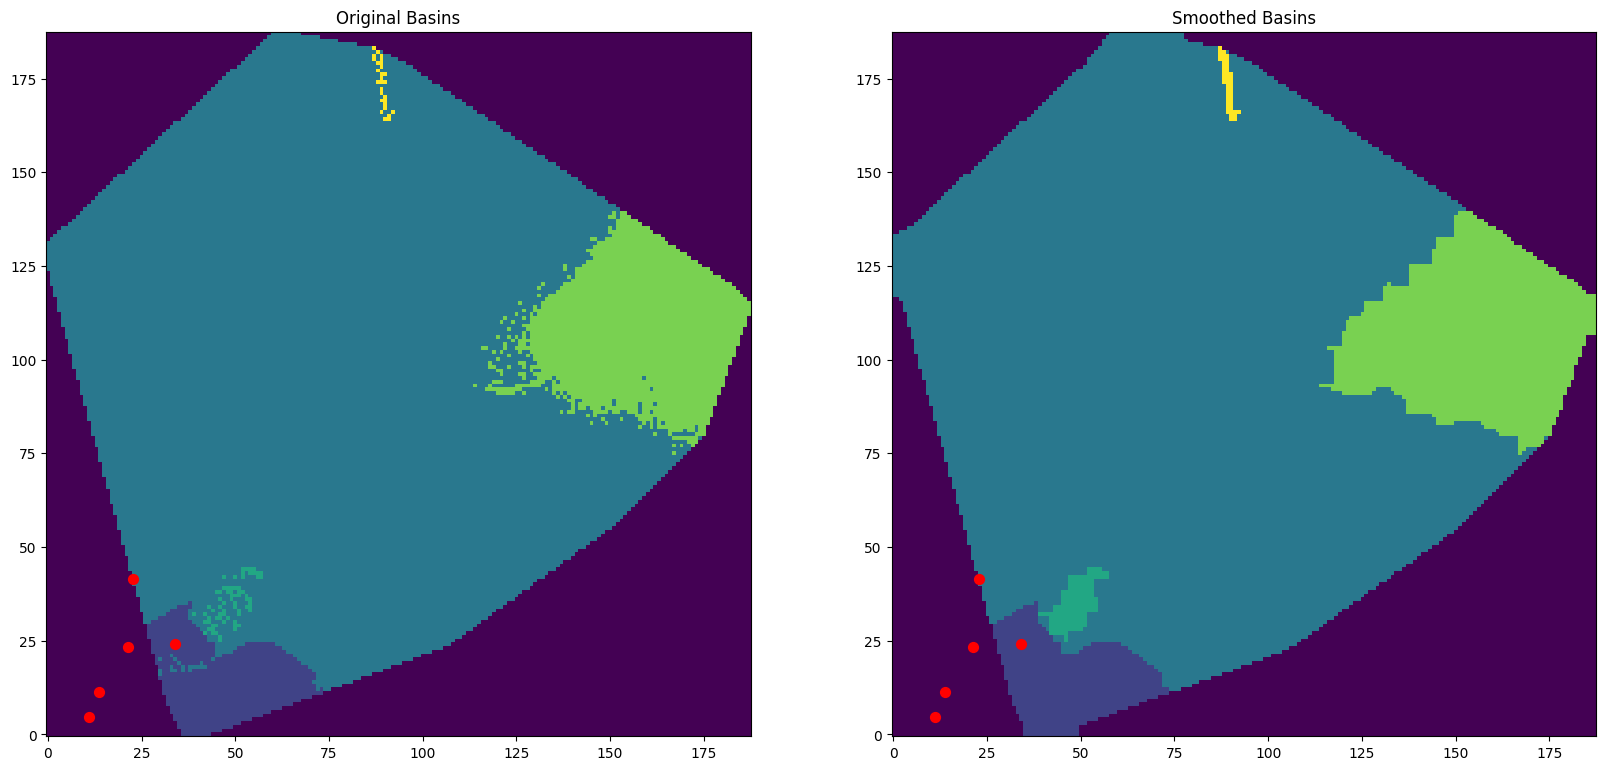

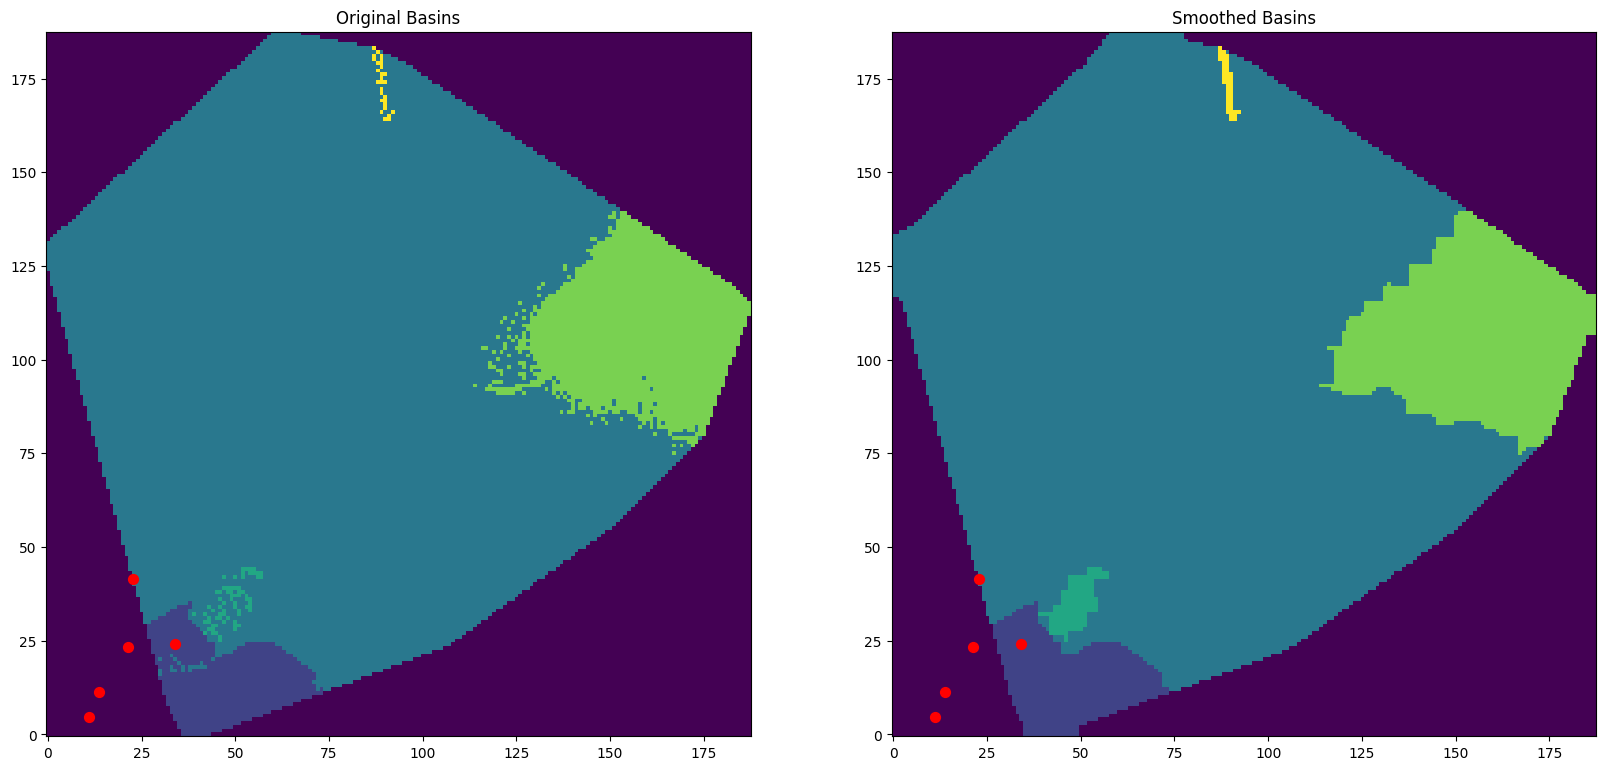

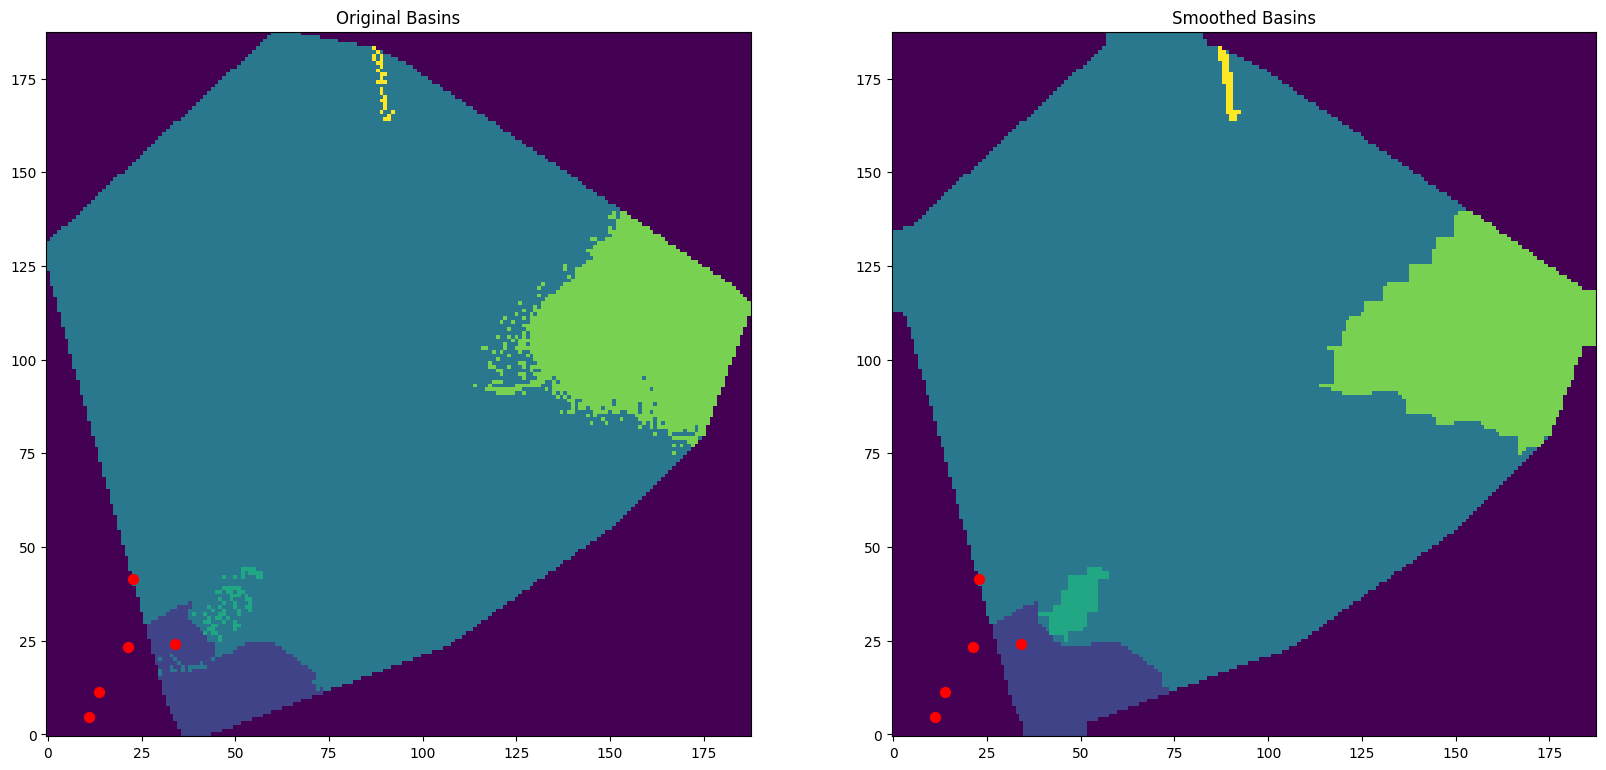

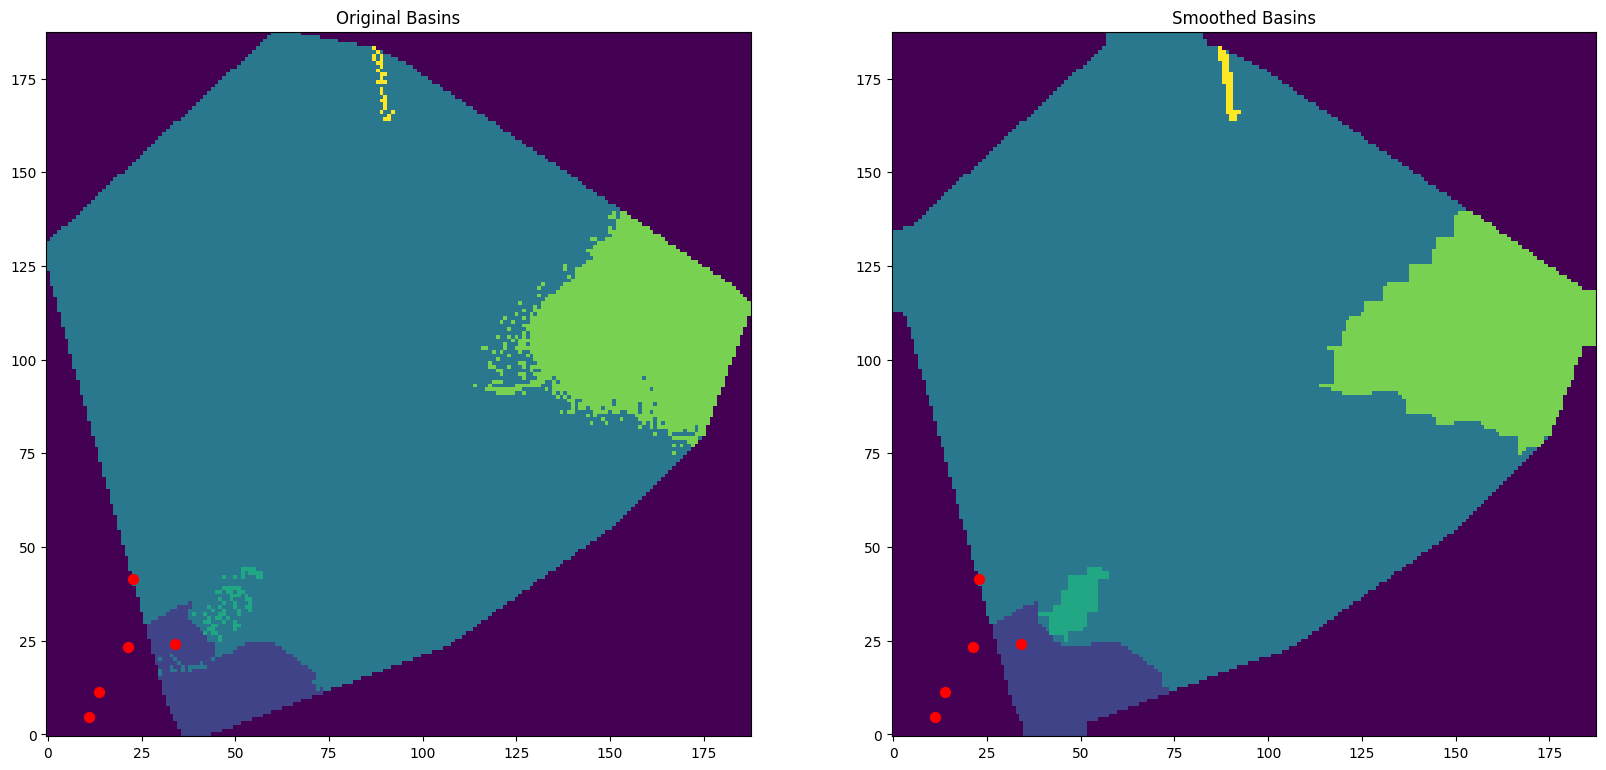

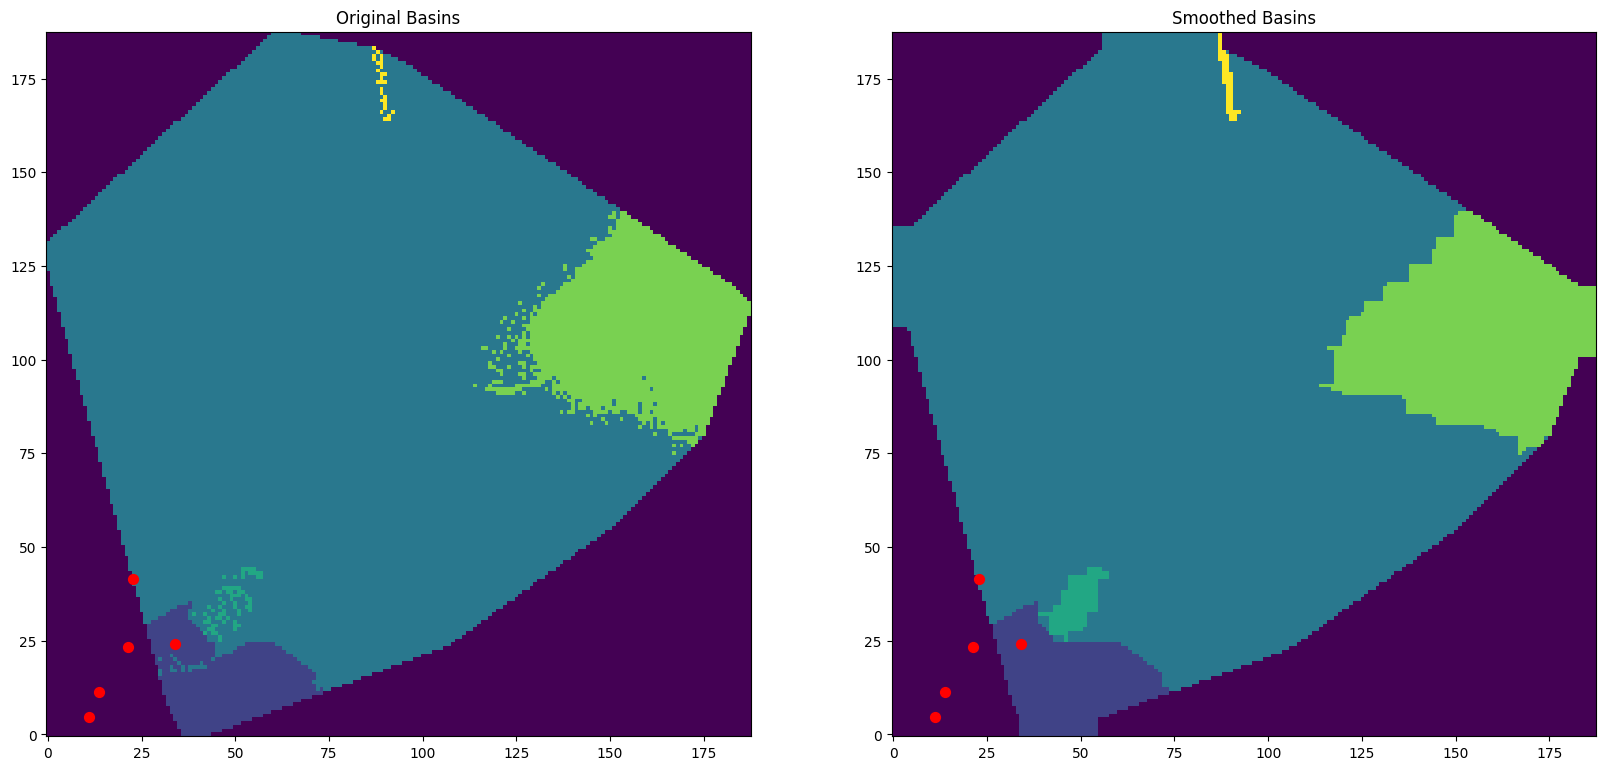

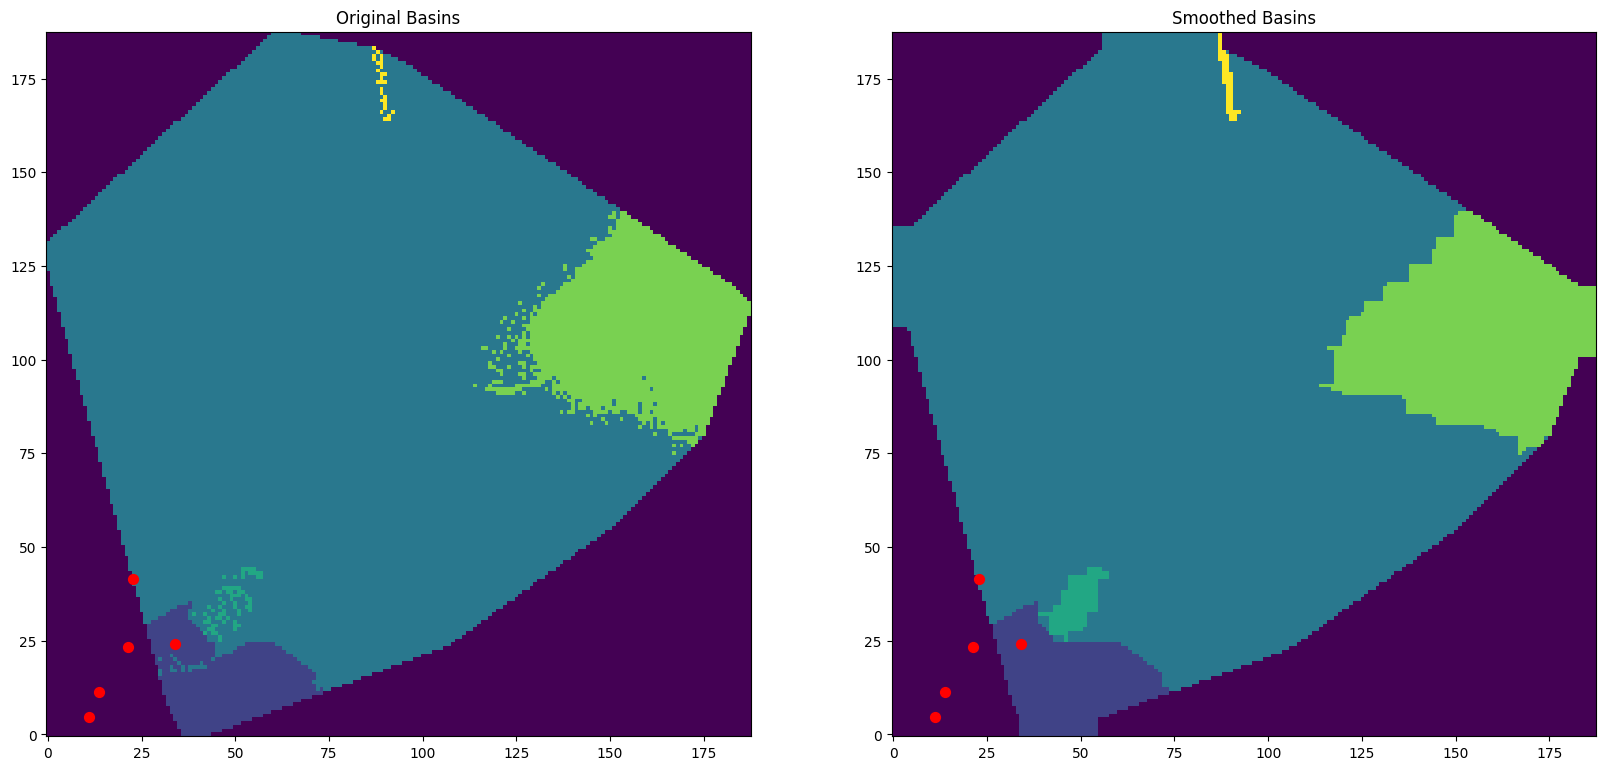

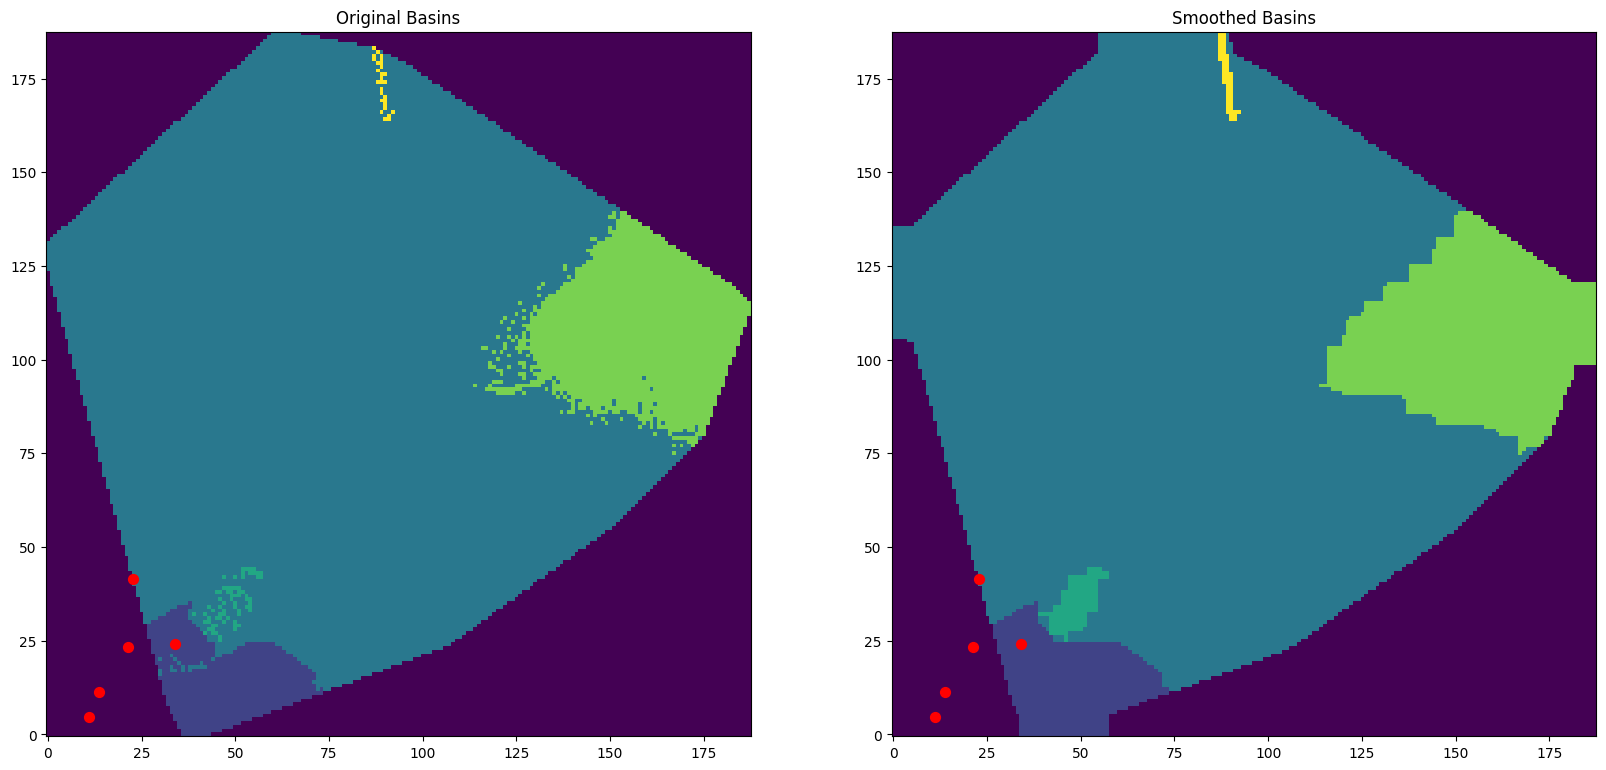

In [160]:
smoother = BasinSmoother(basins, attractors)

# Process with smoothing (try different smoothing factors)
for factor in [2, 3, 4, 5,6,7,8,9,10]:
    smoothed_basins = smoother.process_basins(smooth=True, smoothing_factor=factor)
    smoother.visualize_processed_basins(smoothed_basins, smooth=True)




In [169]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

class BasinSmoother:
    def __init__(self, basins, attractors):
        self.basins = basins
        self.attractors = np.array(attractors)
        self.num_attractors = len(attractors)
        self.shape = basins.shape

    def create_basin_mask(self, attractor_index):
        return (self.basins == attractor_index).astype(np.uint8)

    def smooth_basin(self, mask, smoothing_factor=2, simplification_factor=0.01):
        # Ensure odd-sized kernel by adding 1 if smoothing_factor is even
        kernel_size = smoothing_factor + 1 if smoothing_factor % 2 == 0 else smoothing_factor
        kernel = np.ones((kernel_size, kernel_size), np.uint8)

        # Apply morphological closing to fill small holes and smooth edges
        closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        
        # Find contours of the closed mask
        contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return mask
        
        # Simplify the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        epsilon = simplification_factor * cv2.arcLength(largest_contour, True)
        approx = cv2.approxPolyDP(largest_contour, epsilon, True)
        
        # Create a new mask from the simplified contour
        smooth_mask = np.zeros_like(mask)
        cv2.drawContours(smooth_mask, [approx], 0, 1, -1)
        
        # Ensure all original points are included (prevents orphaned points)
        smooth_mask = np.logical_or(smooth_mask, mask).astype(np.uint8)
        
        return smooth_mask

    def process_basins(self, smooth=True, smoothing_factor=2, simplification_factor=0.01):
        # Calculate basin sizes and strengths
        basin_sizes = np.array([np.sum(self.basins == i) for i in range(self.num_attractors)])
        strengths = 1 / basin_sizes
        strengths = strengths / np.max(strengths)  # Normalize

        # Sort attractors by increasing strength (decreasing basin size)
        sorted_indices = np.argsort(strengths)

        processed_basins = np.full(self.shape, -1, dtype=int)

        for i in sorted_indices:
            mask = self.create_basin_mask(i)
            
            if smooth:
                smooth_mask = self.smooth_basin(mask, smoothing_factor, simplification_factor)
            else:
                smooth_mask = mask

            # Update the processed basins
            processed_basins[smooth_mask == 1] = i

        return processed_basins

    def visualize_processed_basins(self, processed_basins, smooth=True):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        
        # Plot original basins
        ax1.imshow(self.basins, cmap='viridis', interpolation='nearest', origin='lower')
        ax1.scatter(self.attractors[:, 0], self.attractors[:, 1], color='red', s=50)
        ax1.set_title("Original Basins")
        
        # Plot processed basins
        ax2.imshow(processed_basins, cmap='viridis', interpolation='nearest', origin='lower')
        ax2.scatter(self.attractors[:, 0], self.attractors[:, 1], color='red', s=50)
        title = "Smoothed Basins" if smooth else "Original Basins with Resolved Overlaps"
        ax2.set_title(title)
        
        plt.show()

# Usage


# Process without smoothing (original shapes with resolved overlaps)
#original_basins = smoother.process_basins(smooth=False)
#smoother.visualize_processed_basins(original_basins, smooth=False)

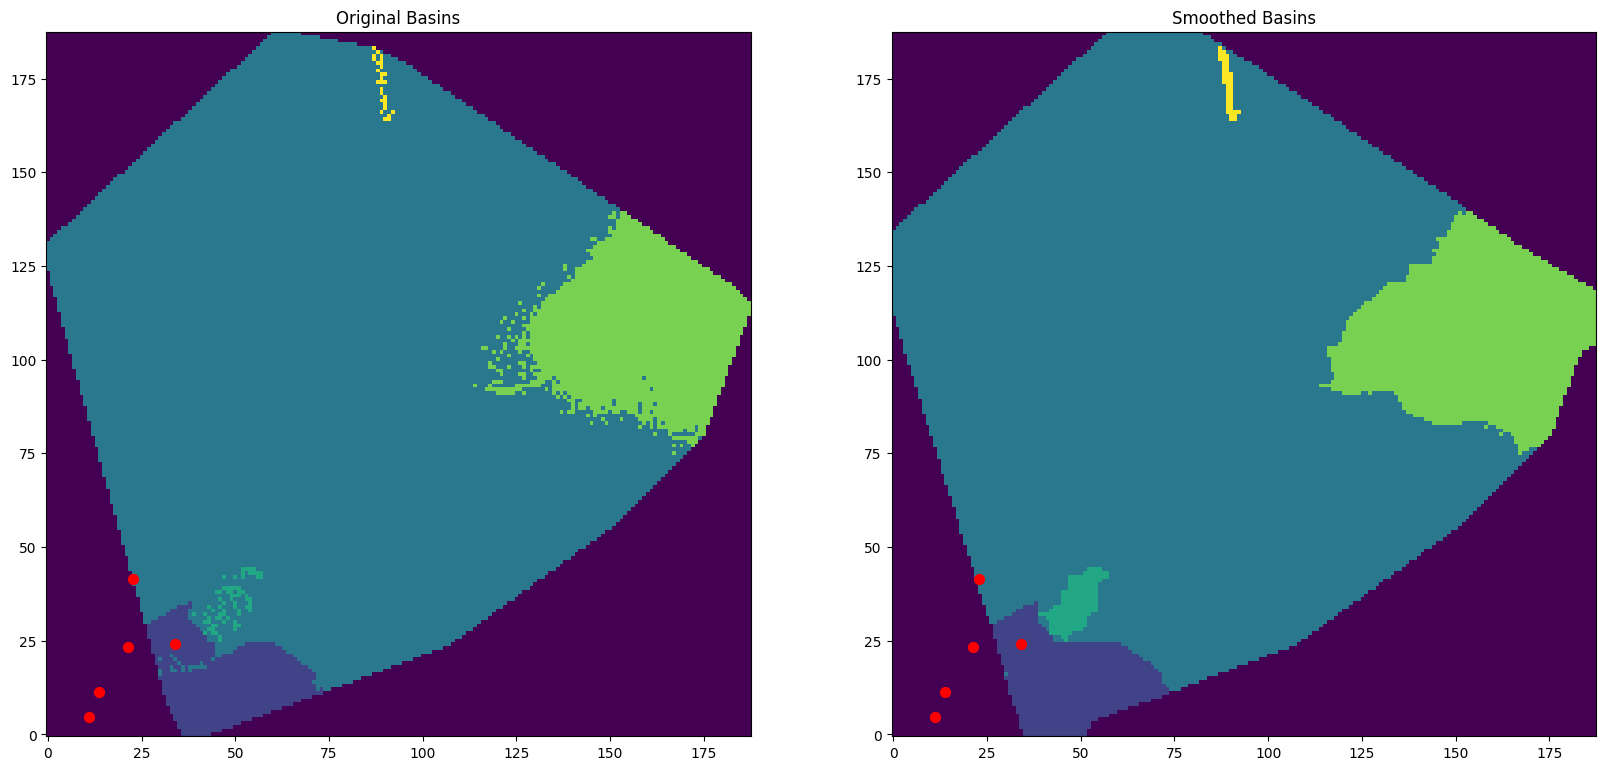

In [188]:
smoother = BasinSmoother(basins, attractors)

# Process with smoothing
smoothed_basins = smoother.process_basins(smooth=True, smoothing_factor=6, simplification_factor=0.01)
smoother.visualize_processed_basins(smoothed_basins, smooth=True)

In [241]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from scipy.spatial import Delaunay

class BasinSmoother:
    def __init__(self, basins, attractors):
        self.basins = basins
        self.attractors = np.array(attractors)
        self.num_attractors = len(attractors)
        self.shape = basins.shape

    def create_basin_mask(self, attractor_index):
        return (self.basins == attractor_index).astype(np.uint8)

    def smooth_basin(self, mask, smoothing_factor=2, simplification_factor=0.01):
        # Ensure odd-sized kernel by adding 1 if smoothing_factor is even
        kernel_size = smoothing_factor + 1 if smoothing_factor % 2 == 0 else smoothing_factor
        kernel = np.ones((kernel_size, kernel_size), np.uint8)

        # Apply morphological closing to fill small holes and smooth edges
        closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        
        # Find contours of the closed mask
        contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return mask
        
        # Simplify the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        epsilon = simplification_factor * cv2.arcLength(largest_contour, True)
        approx = cv2.approxPolyDP(largest_contour, epsilon, True)
        
        # Create a new mask from the simplified contour
        smooth_mask = np.zeros_like(mask)
        cv2.drawContours(smooth_mask, [approx], 0, 1, -1)
        
        # Ensure all original points are included (prevents orphaned points)
        smooth_mask = np.logical_or(smooth_mask, mask).astype(np.uint8)
        
        return smooth_mask

    def fill_holes(self, mask):
        # Find contours of the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # If no contours found, return the original mask
        if not contours:
            return mask
        
        # Create a new mask and fill in the contours
        filled_mask = np.zeros_like(mask)
        cv2.drawContours(filled_mask, contours, -1, 1, -1)
        
        return filled_mask

    def concave_hull_smooth(self, mask, alpha=0.1, spline_smoothness=0, max_iterations=1000):
        # Get boundary points
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return mask
        
        boundary_points = contours[0].squeeze()
        
        # Check if boundary_points is empty or has only one point
        if boundary_points.size == 0 or len(boundary_points.shape) == 1:
            return mask
        
        # Ensure boundary_points is 2D
        if len(boundary_points.shape) > 2:
            boundary_points = boundary_points.reshape(-1, 2)
        
        # Check if we have enough points for triangulation
        if len(boundary_points) < 3:
            return mask

        try:
            # Compute Delaunay triangulation
            tri = Delaunay(boundary_points)

            # Find edges that satisfy alpha criterion
            edges = set()
            for simplex in tri.simplices:
                for i in range(3):
                    j = (i + 1) % 3
                    p1, p2 = boundary_points[simplex[i]], boundary_points[simplex[j]]
                    if np.linalg.norm(p1 - p2) < 1 / alpha:
                        edges.add(tuple(sorted((tuple(p1), tuple(p2)))))

            # Create ordered edge list
            ordered_edges = list(edges)
            if not ordered_edges:
                return mask
            
            hull = [ordered_edges[0][0], ordered_edges[0][1]]
            used_edges = set([ordered_edges[0]])

            iteration = 0
            while len(used_edges) < len(edges) and iteration < max_iterations:
                last_point = hull[-1]
                found_edge = False
                for edge in edges:
                    if edge in used_edges:
                        continue
                    if last_point in edge:
                        next_point = edge[0] if edge[1] == last_point else edge[1]
                        hull.append(next_point)
                        used_edges.add(edge)
                        found_edge = True
                        break
                if not found_edge:
                    # If no edge is found, break the loop to avoid infinite iteration
                    break
                iteration += 1

            hull = np.array(hull)

            # Fit a spline to the hull points
            if len(hull) >= 4:  # Need at least 4 points for a periodic spline
                tck, u = splprep(hull.T, u=None, s=spline_smoothness, per=1)
                u_new = np.linspace(u.min(), u.max(), 1000)
                smooth_hull = np.column_stack(splev(u_new, tck))
            else:
                smooth_hull = hull

            # Create a new mask from the smooth hull
            smooth_mask = np.zeros_like(mask)
            cv2.fillPoly(smooth_mask, [smooth_hull.astype(np.int32)], 1)

            # Fill any holes in the smooth mask
            smooth_mask = self.fill_holes(smooth_mask)

            # Ensure all original points are included
            smooth_mask = np.logical_or(smooth_mask, mask).astype(np.uint8)

            return smooth_mask
        except Exception as e:
            print(f"Error in concave hull smoothing: {e}")
            return mask

    def process_basins(self, smooth=True, smoothing_factor=2, simplification_factor=0.01, alpha=0.1, spline_smoothness=0):
        # Calculate basin sizes and strengths
        basin_sizes = np.array([np.sum(self.basins == i) for i in range(self.num_attractors)])
        strengths = 1 / basin_sizes
        strengths = strengths / np.max(strengths)  # Normalize

        # Sort attractors by increasing strength (decreasing basin size)
        sorted_indices = np.argsort(strengths)

        processed_basins = np.full(self.shape, -1, dtype=int)

        for i in sorted_indices:
            mask = self.create_basin_mask(i)
            
            if smooth:
                # Apply initial smoothing
                smooth_mask = self.smooth_basin(mask, smoothing_factor, simplification_factor)
                # Apply final concave hull smoothing
                smooth_mask = self.concave_hull_smooth(smooth_mask, alpha, spline_smoothness)
            else:
                smooth_mask = mask

            # Update the processed basins
            processed_basins[smooth_mask == 1] = i

        return processed_basins

    def visualize_processed_basins(self, processed_basins, smooth=True):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        
        # Plot original basins
        ax1.imshow(self.basins, cmap='viridis', interpolation='nearest', origin='lower')
        ax1.scatter(self.attractors[:, 0], self.attractors[:, 1], color='red', s=50)
        ax1.set_title("Original Basins")
        
        # Plot processed basins
        ax2.imshow(processed_basins, cmap='viridis', interpolation='nearest', origin='lower')
        ax2.scatter(self.attractors[:, 0], self.attractors[:, 1], color='red', s=50)
        title = "Smoothed Basins" if smooth else "Original Basins with Resolved Overlaps"
        ax2.set_title(title)
        
        plt.show()

# Usage
# smoother = BasinSmoother(basins, attractors)

# # Process with smoothing
# smoothed_basins = smoother.process_basins(smooth=True, smoothing_factor=3, simplification_factor=0.01, alpha=0.1, spline_smoothness=0)
# smoother.visualize_processed_basins(smoothed_basins, smooth=True)

# # Process without smoothing (original shapes with resolved overlaps)
# original_basins = smoother.process_basins(smooth=False)
# smoother.visualize_processed_basins(original_basins, smooth=False)



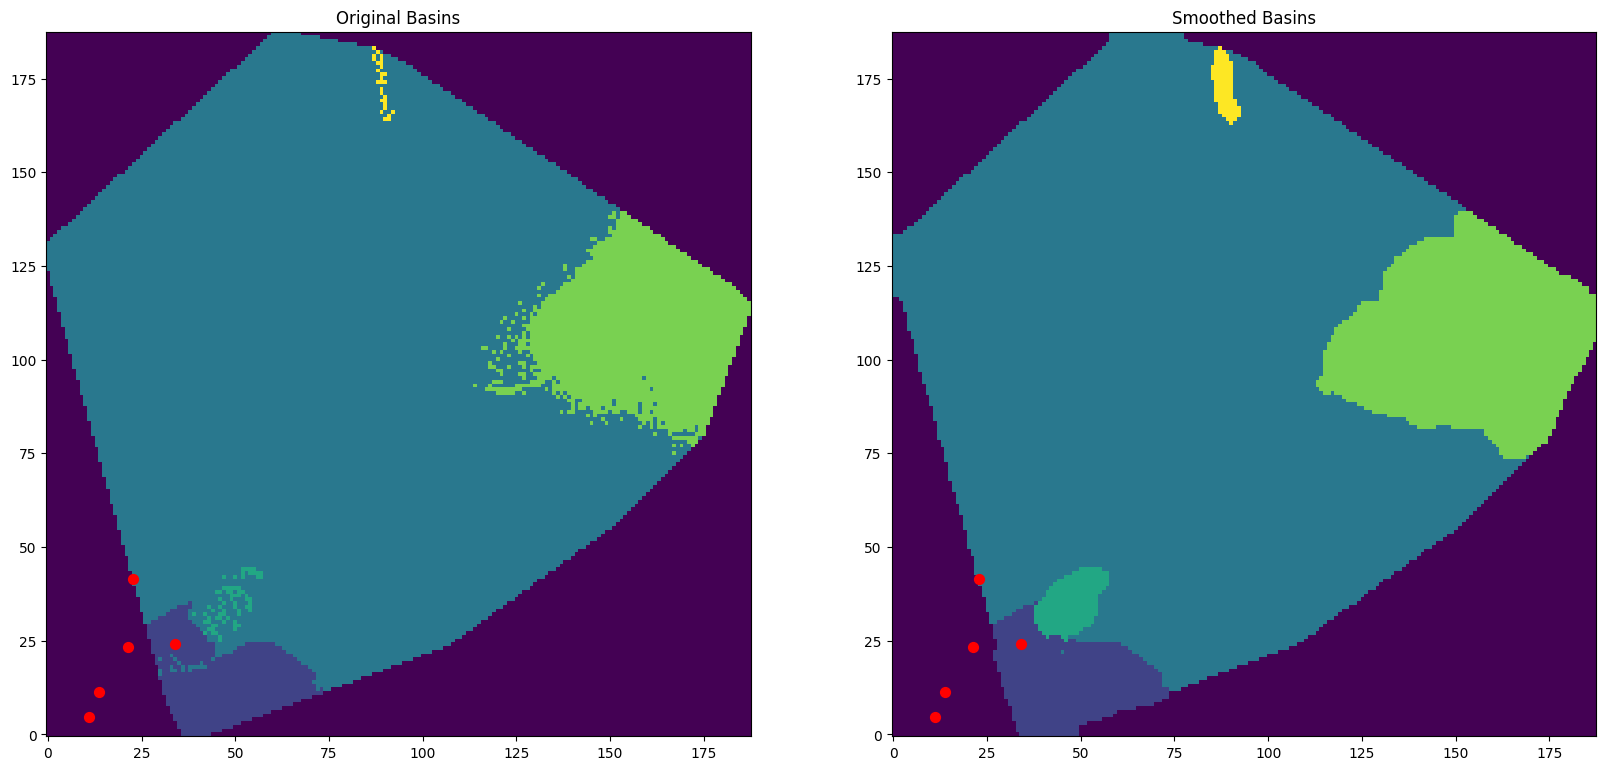

In [247]:
# Usage
smoother = BasinSmoother(basins, attractors)

# Process with smoothing
smoothed_basins = smoother.process_basins(smooth=True, smoothing_factor=5, simplification_factor=0.001, alpha=0.05, spline_smoothness=1)
smoother.visualize_processed_basins(smoothed_basins, smooth=True)



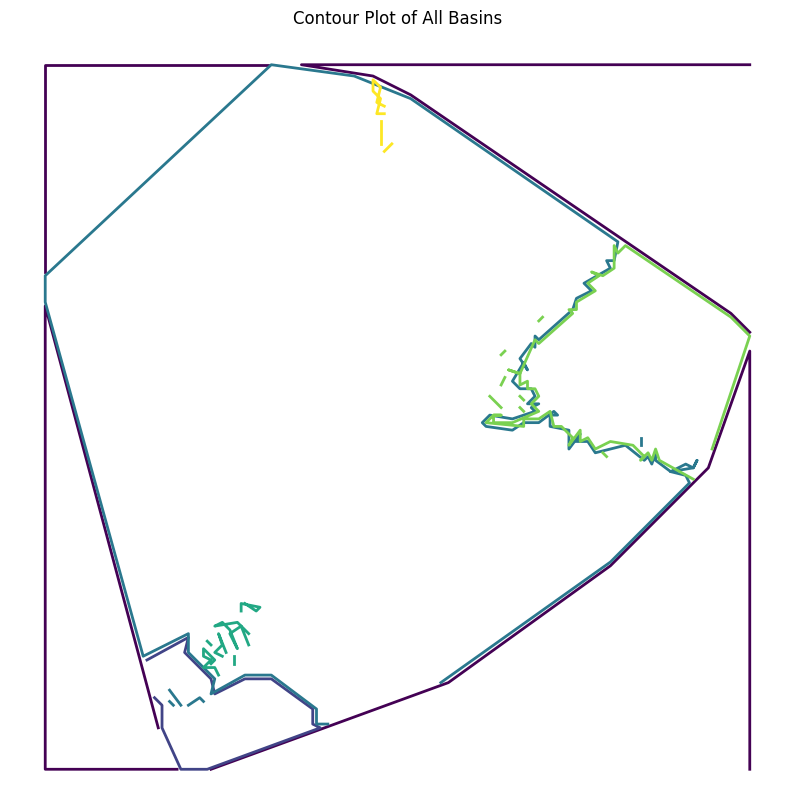

In [30]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming 'basins' is a numpy array loaded from your data.
# Find all unique basin IDs (excluding -1 if it denotes non-basin areas)
unique_ids = np.unique(basins[basins != -1])
n_unique = len(unique_ids)

# Create a colormap
cmap = plt.get_cmap('viridis', n_unique)

# Prepare a plot
plt.figure(figsize=(10, 10))
ax = plt.gca()

# Draw contours for each unique ID
for i, uid in enumerate(unique_ids):
    if uid==-1:
        continue
    # Create a mask where the current basin ID is located
    mask = np.where(basins == uid, 255, 0).astype(np.uint8)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Retrieve the color from the colormap
    color = cmap(i / (n_unique - 1))  # Get color as RGBA

    # Plot each contour
    for contour in contours:
        # Simplify the contour to reduce the number of points
        contour = cv2.approxPolyDP(contour, 1, True)
        contour = contour[:, 0, :]  # Reshape contour array
        ax.plot(contour[:, 0], contour[:, 1], linewidth=2, color=color)

# Configure the plot
ax.set_title('Contour Plot of All Basins')
ax.set_aspect('equal', adjustable='datalim')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()




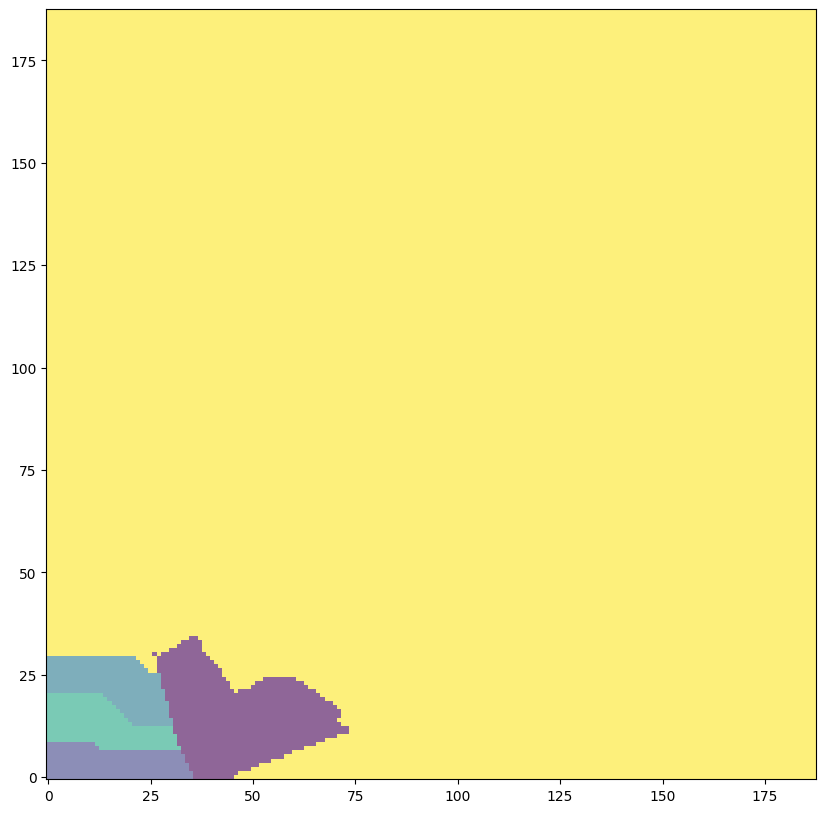

In [532]:
plt.figure(figsize=(12, 10))
plt.imshow(segmented, 
                   origin='lower', alpha=0.6, cmap='viridis')

In [23]:
def plot_vector_field_with_trajectories(df, scale=1, trajectory=None):
    # Plotting the vector field
    fig, ax = plt.subplots(figsize=(12, 10))
    Q = ax.quiver(
        df['from_x'], df['from_y'], 
        df['mu_dx']*scale, df['mu_dy']*scale,  # Scale the vectors
        angles='xy', scale_units='xy', scale=1,
        pivot='mid'
    )
    
    # If trajectory is provided, plot it
    if trajectory is not None:
        # Convert trajectory from (row, col) to (x, y)
        
        # Plot the trajectory
        ax.plot(trajectory[:, 0], trajectory[:, 1], 'r-', linewidth=2, label='Trajectory')
        
        # Plot start and end points
        ax.plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=10, label='Start')
        ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', markersize=10, label='End')
    
    # Set labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Vector Field with Trajectory')
    
    # Adjust plot limits to show full extent of vector field and trajectory
    x_min, x_max = df['from_x'].min(), df['from_x'].max()
    y_min, y_max = df['from_y'].min(), df['from_y'].max()
    
    plt.grid(True)
    plt.legend()
    plt.show()

/home/jeintron/dev/blf_m/attractor.3.11.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


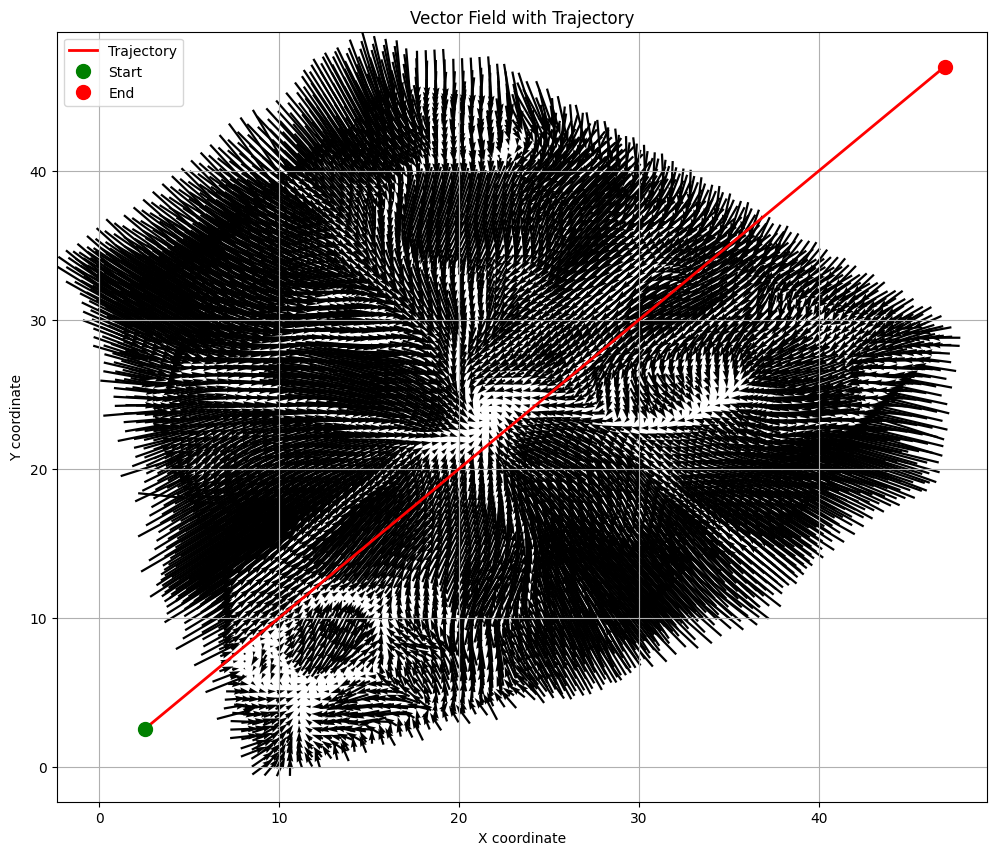

In [427]:
trajectory=analyzer.generate_trajectory((5,5),step_size=1)
traj_xy = np.array(convert_trajectory_to_xy(trajectory))
plot_vector_field(fine_field,scale=1,trajectory=traj_xy)